# Global Seawater Oxygen-18 Database #

Hello! Thanks for your interest in the Global Seawater Oxygen-18 Database. This iPython Notebook is intended to teach how to update, sort, and leverage the database for some basic statistical anlysis and spatial-temporal visualization. All files necessary to run this notebook are found on the <a href='https://github.com/yinleon/NASA'>github repo</a>.
<br>There is also a fun interactive map <a href='https://github.com/yinleon/NASA/blob/master/interactiveMap.ipynb'>here</a>.

# Table of Contents <a id='h'></a>
<a href='#1'>1 Introduction</a><br>
<a href='#1.1'>&rarr;1.1 Updating Database</a><br>
<a href='#1.2'>&rarr;1.2 Removing Outliers</a><br>
<a href='#1.3'>&rarr;1.3 Outputting Database</a><br>
<a href='#2'>2 Statio-Temporal Data Visualization</a><br>
<a href='#2.1'>&rarr;2.1 Searching the Database</a><br>
<a href='#2.2'>&rarr;2.2 Seasonal Distribution</a><br>
<a href='#2.3'>&rarr;2.3 Interannual Distritubion</a><br>
<a href='#2.4'>&rarr;2.4 Study Distribution</a><br>
<a href='#3'>3 Reigonal Partioning in the Arctic Ocean</a><br>
<a href='#4'>4 Statistical Analysis</a><br>
<a href='#4.1'>&rarr;4.1 Monthly δ18O-S Variability</a><br>
<a href='#4.2'>&rarr;4.2 Reigonal δ18O-S Relationships</a><br>
<a href='#4.3'>&rarr;4.3 Jackknife Slope Analysis</a><br>
<a href='#5'>5 Plotting the Global Gridded Dataset</a><br>

# Acknowledgement <a id='intro'></a>
The Global Seawater Oxygen-18 Database was compiled by NASA GISS director Gavin Schmidt in 1999 and subsequently leveraged by Allegra L. LeGrande to calculate a 1x1 Global Gridded Data set in 2006. Thanks to NASA GISS education director Matt Pearce and my teammates Cassandra kopas-johnson, Susan Kelly and our mentor and Allegra N. LeGrande.
## An introduction to Oxygen-18
The ratio of the heavy isotope Oxygen-18 to Oxygen-16 is roughly 2000:10<sup>6</sup> and is standardized in δ<sup>18</sup>O permilli notation. δ<sup>18</sup>O is typically found in corals, foraminifera and ice cores as a climate proxy for temperature. For this study, we use δ<sup>18</sup>O in seawater to measure the origin and mixing of freshwater sources. As water vapor evaporates from the Ocean surface it rises, cools, and precipitates over the sea. Due to the thermodynamic favorability of the heavy isotope, it is preferentially rained out. When the cloud of water vapor reaches land, it is deplete of heavy isotopes. The severity of this depletion is geographically consistent with the precipitation out site (Mountain top). For this reason, we can trace specific δ<sup>18</sup>O fingerprints to their source. When the freshwater is returns to the sea, it gets δ<sup>18</sup>O-enriched and salty. With that in mind we can create a linear regression between salinity and δ<sup>18</sup>O to recover reigonal end-members (Y-intercept) and mixing (slope). This tool is especially useful for validating Ocean circulation and hydrology in general circulation models (GCMs).
## Some words about the software
This software was written in the Summer of 2015 for NASA GISS' New York Reserach Intiative using Python.
It has been repurposed for this iPython notebook and contains supplementary data files and a fortran script.
This Notebook is intended to be downloaded and run, because of this the index links from the table of contents will not work on github!
<br><br>Last edited 10.15.15 by <a href='https://yinleon.github.io'>Leon Yin</a>.

## Before we Begin...
Let's import some modules in[1] and set some universal parameters in[2].
<br> You may need to download Pandas, Seaborn, Basemaps (I like using 'easy install' in the Terminal commandline).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, colorsys, seaborn
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import spline
from IPython.display import Image
%matplotlib inline

Let's keep a record of all our files: the ASCII input file can be found on the <a href='http://data.giss.nasa.gov/o18data/dbO18.txt.gz'>NASA GISS</a> website (NOTE ASCII.dat==ASCII.txt) and the output files can be written in fixed-width ASCII and CSV.

In [2]:
# files
filein      = 'dbO18.txt'       # this file is downloaded from the d18o website.
fileout     = 'dbO18_2015.txt'  # output of the entire DB as a fixed-width txt/ASCII format
csvout      = 'dbO18_2015.csv'  # replace 2015 with specifics!
WOAF        = 'WOAsalMonthly.nc' # Average monthly salinity from WOA2001 in NetCDF

# params
surfDep     =  10               # depth of ocean observed
cmap1       = "jet"             # color map
Vmin        = -5.6              # color bar min (del O18 min)
Vmax        =  2.6              # color bar max (del O18 max)
titleS      =  16               # title font size
figX        =  9                # figure width (short)
figX1       =  12               # figure width (long)
figY        =  9                # figure height
markScat    =  12               # scatter marker size
linWid      =  3.5              # width of line plots
skip        = -99.9             # database skip value

# 1 Let's get started... <a id='1'></a>#
Next it's time to upload the fixed-width ASCII database file into Pandas DF in[3].
Pandas has thorough <a href='http://pandas.pydata.org/pandas-docs/stable/tutorials.html'>documentation</a> on their website.
Thanks to Pandas, there are dynamic database (DB) querrying for any of the 11 fields-- including seasonality, reference, and location.
<br><a href='#h'>Top</a>

In [3]:
# Global Seawater d18O database format.
col=\
  ['lon','lat','month','year','depth','temp', 'sal', 'd18o','dD','notes','ref'] 
fWid=( 7,    6,      2,     4,      5,     6,     6,      6,   6,    15,   60)

# Read in Database into a Pandas Dataframe data structure
if(os.path.isfile(filein)):
    df=pd.read_fwf(filein,widths=fWid,header=None,names=col,skip_blank_lines=True)
    ogLen     = len(df.index-1) # number of records in DF from filein
    print ogLen,"records from Global Seawater Oxygen-18 Database imported to dataframe df."
else:
    print filein,"is either unreadable or DNE."
    raise SystemExit(0)

# some variables...
dfRows    = len(df.index-1) # number of records in current DF
ogLen     = len(df.index-1) # number of records in DF from filein

25514 records from Global Seawater Oxygen-18 Database imported to dataframe df.


## 1.1 Updating the Database with New Case Studies <a id='1.1'></a> ##
Now that the database is uploaded into a Pandas data frame, we can add new files from CSV files with column order:
<br>lon(-180,180), lat(-90,90), month(1,12), year(####), depth(m), temp(C), sal(g/kg), d18o(‰), dD(‰), notes, ref
<br>Please be advised that these files are unpublished and not publically avaiable at this time, instead a properly formatted submission template is visable <a href='https://github.com/yinleon/NASA/blob/master/template.csv'>here</a>.
<br><a href='#h'>Top</a>

In [4]:
# an example of a list of properly formatted csv files to add to the DB.
toAdd     = ('Strauss2015.csv','Cases2012.csv','COX2010_2001.csv',
              'Conroy2012.csv','Tiwari2013.csv','BROWN2014.csv',
              'GeoRijkenberg2011.csv','GeoJenkins2010.csv')    

files2Add = len(toAdd)      # number of sources to add

for i in range(files2Add):
    if(os.path.isfile(toAdd[i])==False):
        print toAdd[i],"is either unreadable or DNE."
        raise SystemExit(0)
   
print"Integrating CSV into Global D18O Seawater Database..."    
for i in range(0,files2Add):
    csv2DF=pd.read_csv(toAdd[i],sep=',',skiprows=1,names=col,na_filter=True)
    #              File Name,Delimiter, skip header
    dfRows= len(df.index-1)
    df = df.append(csv2DF)  # add contents of new csv into DB.
    dfRows= len(df.index-1) # update the number of records in DB.
print dfRows-ogLen,"records added to the database."
print dfRows,"total records"

Integrating CSV into Global D18O Seawater Database...
2942 records added to the database.
28456 total records


## 1.2 Removing Outliers <a id='1.2'></a> ##
Outliers can be identified using <a href='#4.2'>Jackknife Slope Analysis</a>, which comes in hand down the line when distinguishing and merging <a href='#4.1'>reigonal water masses</a>. Let's leave this empty for now, but we can <a href='#return'>revisit it down the line</a>...
<br><a href='#h'>Top</a>

In [5]:
# place all Outlier ID's in list below...
idOdeath    = []
lenOdeath   = len(idOdeath)
for toKill in range(lenOdeath):     # filters DF by natural index.
    df = df[df.index != idOdeath[toKill]]
print lenOdeath,"outlier(s) ELIMINATED!"
dfRows    = len(df.index-1)
print("\m/ -___- \m/")
print dfRows,"Records remain"

0 outlier(s) ELIMINATED!
\m/ -___- \m/
28456 Records remain


## 1.3 Outputting the Database <a id='1.3'></a>##
The dataframe can be output into CSV and ASCII fixed-width with the following functions.
<br><a href='#h'>Top</a>

In [6]:
def convert2CSV(df,csvout):
    df2csv = 'dbo18_2015.csv'
    toCSV=pd.DataFrame.to_csv(df2csv,sep=',',line_terminator='\n')
    csvout = open(csvout, 'w')      # opens the file to write into
    csvout.write(toCSV)             # writes df to csv... 
    print "Database transferred to csv..."
    csvout.close()


def writeOut(df):
    df=df.fillna('')                #replace NaN values with spaces
    temp = 'temp.txt'       
    dbOut = open(temp, 'w')
    v = df.values.T.tolist()        # The DF must be converted to a list first.
    for i in range(0,dfRows):       # Right each row into the file.
        dbOut.write(( \
        '{:7.2f}{:>6.2f}{:>2.0f}{:>4.0f}{:>5.0f}{:6.2f}{:6.2f}{:6.2f}{:6.1f}{:>15}{:>60}'\
        .format(v[0][i],v[1][i],v[2][i],v[3][i],v[4][i],v[5][i],v[6][i],v[7][i],v[8][i],\
        v[9][i],v[10][i]) ))
        dbOut.write("\n")
    dbOut.close
    # swap -99.90 with -99.9
    with open(fileout, "wt") as fout:
        with open(temp, "rt") as fin:
            for line in fin:
                fout.write(line.replace('-99.90', ' -99.9'))
    print "Database transferred to txt..."
    fout.close
    fin.close
    os.remove(temp)                 # Remove the temporary file.

# 2 Statio-Temporal Data Visualization <a id='2'></a> #
Looking at <a href='#5'>variability on a global scale</a>, we see a large discrepency between the esimated and calculated observations in the Arctic Ocean.
Now we can plot the updated database and examine the distribution δO<sup>18</sup> and salinity observations.
<br><a href='#h'>Top</a><br>

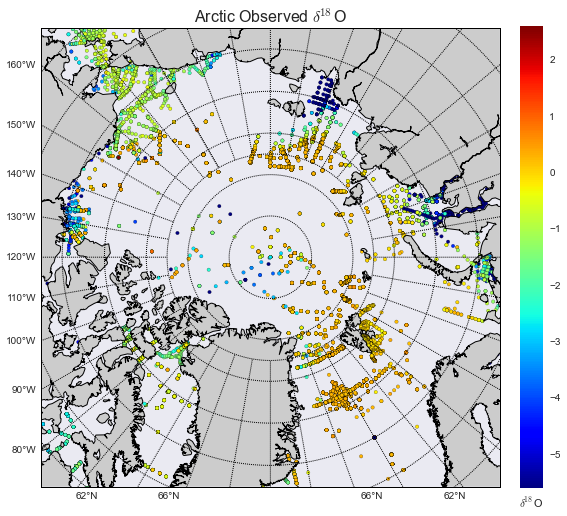

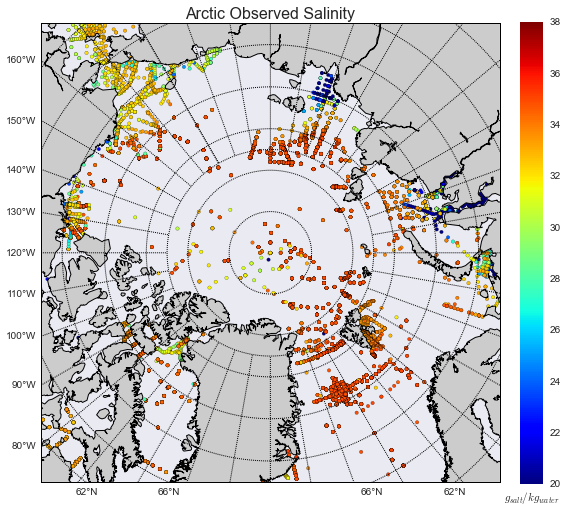

In [7]:
def pltVals():
    plt.figure(figsize=(figX,figY))  
    map = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l')
    parallels = np.arange(-90.,90.,4.)
    meridians = np.arange(-180.,181.,10.)
    map.drawparallels(parallels,labels=[False,False,False,True])
    map.drawmeridians(meridians,labels=[True,False,False,False])
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    #map.bluemarble()
    
    x1 = df.lon.values.T.tolist()
    y1 = df.lat.values.T.tolist()
    z1 = df.d18o.values.T.tolist()
    x, y = map(x1, y1)
    map.scatter(x,y,c=z1,marker='o',s=markScat,linewidth=.2,cmap=cmap1)
    plt.title('Arctic Observed $\delta^{18}$O',fontsize=titleS)
    plt.clim(Vmin,Vmax)
    cbar = plt.colorbar(orientation='vertical',fraction=0.046, pad=0.04)
    cbar.ax.set_xlabel('$\delta^{18}$O')
    #if(save == 1):
        #plt.savefig('valDistro', dpi = 300)
    plt.show()
    
    plt.figure(figsize=(figX,figY))  
    map = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l')
    parallels = np.arange(-90.,90.,4.)
    meridians = np.arange(-180.,181.,10.)
    map.drawparallels(parallels,labels=[False,False,False,True])
    map.drawmeridians(meridians,labels=[True,False,False,False])
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    #map.bluemarble()
    
    x1 = df[df.sal!=skip].lon.values.T.tolist()
    y1 = df[df.sal!=skip].lat.values.T.tolist()
    z1 = df[df.sal!=skip].sal.values.T.tolist()
    
    x, y = map(x1, y1)
    map.scatter(x,y,c=z1,marker='o',s=markScat,linewidth=.2,cmap=cmap1)
    plt.title('Arctic Observed Salinity',fontsize=titleS)
    plt.clim(20,38)
    cbar = plt.colorbar(orientation='vertical',fraction=0.046, pad=0.04)
    cbar.ax.set_xlabel('$g_{salt} / kg_{water}$')
    #if(save == 1):
        #plt.savefig('valDistro', dpi = 300)
    plt.show()
# run it!
pltVals()

We see salty δO<sup>18</sup> depleted water coming from the Atlantic and fresher δO<sup>18</sup> enriched water coming from the Pacific. The most fresh and δO<sup>18</sup> deplete waters originate from the Laptev Sea (discharged from Lena river) and the Kara Sea (discharged from the Ob and Yenisey River). Moreover we see a steady gradient of δO<sup>18</sup> enrichment and brine as we go from the Coastal Kara and Laptev towards the open sea. There are also sparse observations in areas of Sea ice cover.

## 2.1 Searching <a id='2.1'></a> ##
Use this function to search within one field (column) several values.
Make sure args are: search(dataframe, string of field, list of search results)
As an exmaple we're going to separate the Winter months from the database...
<br><a href='#h'>Top</a><br>

Found 3729 instances of month with values of: (12, 1, 2)
Found 38 references containing search results (in refList)...



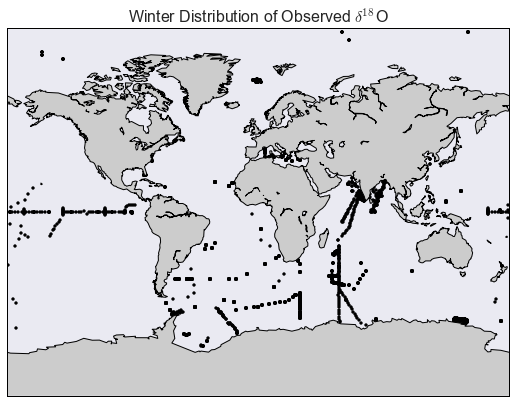

In [8]:
def search(fromCol,values):
     # How many automations/searches are required?
    uniqueVal   = len(values)      
    # Collect values from specified col into new DF.    
    querry = df.loc[df[fromCol] == values[0]]
    for i in range(1,uniqueVal):
        querry=querry.append(df.loc[df[fromCol] == values[i]])
    print"Found",len(querry),"instances of",fromCol,"with values of:",values
    
    # Book keeping...
    refList = querry.ref.unique()   # List of search-relevant references.
    refSize = refList.size
    print"Found",refSize,"references containing search results (in refList)...\n"
    
    # plot the results! Below is optional
    plt.figure(figsize=(figX,figY))
    map = Basemap(projection='mill', lat_0=0, lon_0=0)
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    
    x1 = querry.lon.values.T.tolist()
    y1 = querry.lat.values.T.tolist() 
    x, y = map(x1, y1)
    
    map.scatter(x, y, marker='o',color='k',s=9)
    plt.title(r'Winter Distribution of Observed $\delta^{18}$O',size=titleS)
    plt.show

# search params
fromCol     = 'month'           # What column are you interested in?(ln:72)
values      = (12,1,2)          # Put what you're looking for here!
# run it!
search(fromCol,values)

## Seasonal Distribution <a id='2.2'></a>##
Building off this example, we can partition the dataframe into four seasons. <a id='2.2'></a>
<br><a href='#h'>Top</a><br>

found 3729 instances of month with values of: (12, 1, 2) from 38 unique references
found 6688 instances of month with values of: (3, 4, 5) from 54 unique references
found 6958 instances of month with values of: (6, 7, 8) from 66 unique references
found 9190 instances of month with values of: (9, 10, 11) from 56 unique references


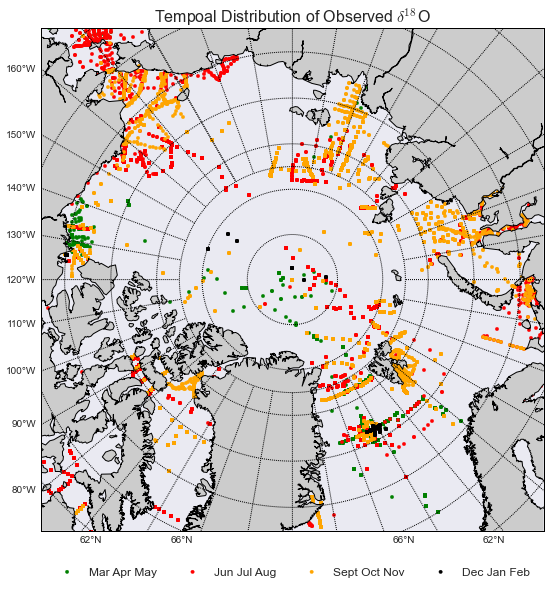

In [9]:
def pltSeason():
    # Seasonal split!
    fromCol     = 'month'           # What column/field are we interested in?
    winter      = (12,1,2)          # Winter Months
    spring      = (3,4,5)           # Spring Months
    summer      = (6,7,8)           # Summer Months
    fall        = (9,10,11)         # Fall Months (my favorite...)
    uniqueVal   = len(winter)       # This is for automation'ssake
    
    #   Section off winter months  
    querryW = df.loc[df[fromCol] == winter[0]]
    for i in range(1,uniqueVal):
        querryW=querryW.append(df.loc[df[fromCol] == winter[i]])
    refListW = querryW.ref.unique()
    refSize = refListW.size
    print"found",len(querryW),"instances of",fromCol,"with values of:",winter,\
    "from",refSize,"unique references"
    
    # Section off spring months  
    querryS = df.loc[df[fromCol] == spring[0]]
    for i in range(1,uniqueVal):
        querryS=querryS.append(df.loc[df[fromCol] == spring[i]])
    refListS = querryS.ref.unique()
    refSize = refListS.size
    print"found",len(querryS),"instances of",fromCol,"with values of:",spring,\
    "from",refSize,"unique references"
    
    # Section off summer months
    querrySM = df.loc[df[fromCol] == summer[0]]
    for i in range(1,uniqueVal):
        querrySM=querrySM.append(df.loc[df[fromCol] == summer[i]])
    refListSM = querrySM.ref.unique()
    refSize = refListSM.size    
    print"found",len(querrySM),"instances of",fromCol,"with values of:",summer,\
    "from",refSize,"unique references"
    
    # section off fall months
    querryF = df.loc[df[fromCol] == fall[0]]
    for i in range(1,uniqueVal):
        querryF=querryF.append(df.loc[df[fromCol] == fall[i]])
    refListF = querryF.ref.unique()
    refSize = refListF.size
    print"found",len(querryF),"instances of",fromCol,"with values of:",fall,\
    "from",refSize,"unique references"   
    
    # plot the dictributions...
    plt.figure(figsize=(figX,figY))
    # global projections
#    map = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,
#    llcrnrlon=-180,urcrnrlon=180,resolution='c')
    # Arctic projection    
    map = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l')
    parallels = np.arange(-90.,90.,4.)
    map.drawparallels(parallels,labels=[False,False,False,True])
    meridians = np.arange(-180.,181.,10.)
    map.drawmeridians(meridians,labels=[True,False,False,False])
    
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    
    #establish lon and Lat per season...    
    x1 = querryS.lon.values.T.tolist()
    y1 = querryS.lat.values.T.tolist() 
    xS, yS = map(x1, y1)
    map.scatter(xS, yS, marker='o',color='g',label='Mar Apr May',s=markScat)

    x1 = querrySM.lon.values.T.tolist()
    y1 = querrySM.lat.values.T.tolist() 
    xSM, ySM = map(x1, y1)
    map.scatter(xSM, ySM, marker='o',color='r',label='Jun Jul Aug',s=markScat)

    x1 = querryF.lon.values.T.tolist()
    y1 = querryF.lat.values.T.tolist() 
    xF, yF = map(x1, y1)
    map.scatter(xF, yF, marker='o',color='orange',label='Sept Oct Nov',s=markScat)

    x1 = querryW.lon.values.T.tolist()
    y1 = querryW.lat.values.T.tolist() 
    xW, yW = map(x1, y1)
    map.scatter(xW, yW, marker='o',color='k',label='Dec Jan Feb',s=markScat)
    # stuff so the for legend is saved w/ the fig!
    art = []
    lgd = plt.legend(loc='upper center',scatterpoints=1,ncol=4,
         bbox_to_anchor=(0.5, -0.05),prop={'size':12})
    art.append(lgd)      
    
    plt.title(r'Tempoal Distribution of Observed $\delta^{18}$O',size=titleS)
    plt.show
    #if (save ==1):
        #plt.savefig('seasonality.png', bbox_inches="tight",
                   # additional_artists=art,format='png',dpi = 300)
    # Bookkeeping...    
    seasonDF = (querryF,querryW,querryS,querrySM)
pltSeason()

## Perhaps there is a better representation... ##
Due to the harsh icy conditions of the Arctic, most observations occur in warmer months. To get the most from our data, we can parse the database between the sea ice growth (starting in October) and loss (ending in March).
<br><a href='#h'>Top</a><br>

found 12687 instances of month with values of: (1, 2, 3, 4, 10, 11, 12) from 78 unique references
found 13878 instances of month with values of: (5, 6, 7, 8, 9) from 85 unique references


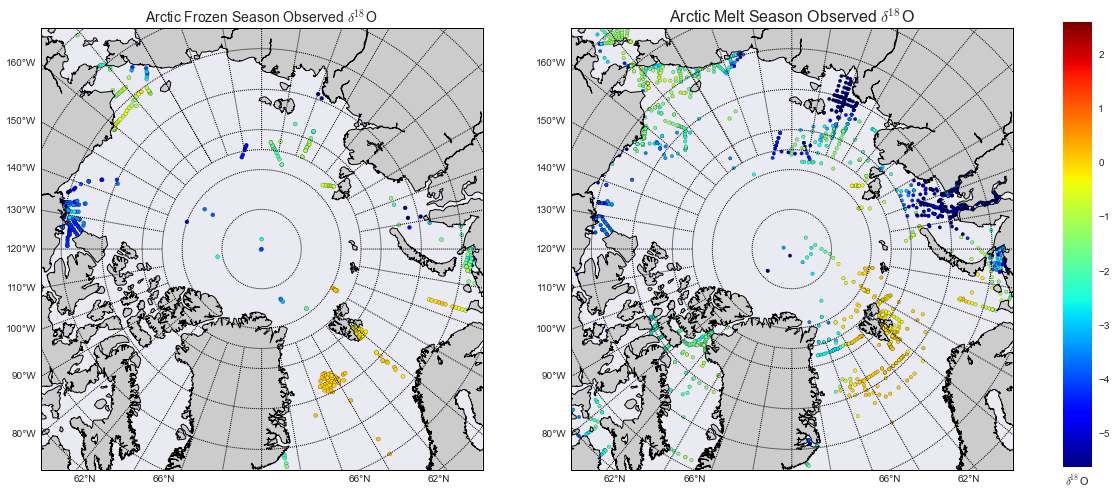

In [10]:
def pltMelt(writeOutIce):  
    fromCol = 'month'           # What column/field are we interested in?
    ice     = (1,2,3,4,10,11,12)    # Winter Months
    water   = (5,6,7,8,9)           # Spring Months may-sept
    iLen    = len(ice)
    wLen    = len(water)            # This is for automation'ssake
    
    #   Section off frozen months  
    iceDF = df.loc[df[fromCol] == ice[0]]
    for i in range(1,iLen):
        iceDF=iceDF.append(df.loc[df[fromCol] == ice[i]])
    refListIce = iceDF.ref.unique()
    refSize = refListIce.size
    print"found",len(iceDF),"instances of",fromCol,"with values of:",ice,\
    "from",refSize,"unique references"
    
    # Section off melt months  
    waterDF = df.loc[df[fromCol] == water[0]]
    for i in range(1,wLen):
        waterDF=waterDF.append(df.loc[df[fromCol] == water[i]])
    refListWater = waterDF.ref.unique()
    refSize = refListWater.size
    print"found",len(waterDF),"instances of",fromCol,"with values of:",water,\
    "from",refSize,"unique references"
   
   # write the DB for ice and melt into .dat files for global gridded dataset.
    if (writeOutIce == 1):
        # Ice season
        iceDf=iceDF.fillna('')
        temp = 'temp.txt'
        fileout = 'ice.dat'     
        dbOut = open(temp, 'w')
        v = iceDf.values.T.tolist()        # The DF must be converted to a list first.
        for i in range(0,len(iceDF)):       # Right each row into the file.
            dbOut.write(( \
            '{:7.2f}{:>6.2f}{:>2.0f}{:>4.0f}{:>5.0f}{:6.2f}{:6.2f}{:6.2f}{:6.1f}{:>15}{:>60}'\
            .format(v[0][i],v[1][i],v[2][i],v[3][i],v[4][i],v[5][i],v[6][i],v[7][i],v[8][i],\
            v[9][i],v[10][i]) ))
            dbOut.write("\n")
        dbOut.close
        # swap -99.90 with -99.9
        with open(fileout, "wt") as fout:
            with open(temp, "rt") as fin:
                for line in fin:
                    fout.write(line.replace('-99.90', ' -99.9'))
        print "Database transferred to txt..."
        fout.close
        fin.close
        os.remove(temp) 
        
        # Time for meltseason
        waterDf=waterDF.fillna('')
    
        fileout = 'melt.dat'
        dbOut = open(temp, 'w')
        v = waterDf.values.T.tolist()        # The DF must be converted to a list first.
        for i in range(0,len(waterDF)):       # Right each row into the file.
            dbOut.write(( \
            '{:7.2f}{:>6.2f}{:>2.0f}{:>4.0f}{:>5.0f}{:6.2f}{:6.2f}{:6.2f}{:6.1f}{:>15}{:>60}'\
            .format(v[0][i],v[1][i],v[2][i],v[3][i],v[4][i],v[5][i],v[6][i],v[7][i],v[8][i],\
            v[9][i],v[10][i]) ))
            dbOut.write("\n")
        dbOut.close
        # swap -99.90 with -99.9
        with open(fileout, "wt") as fout:
            with open(temp, "rt") as fin:
                for line in fin:
                    fout.write(line.replace('-99.90', ' -99.9'))
        print "Database transferred to txt..."
        fout.close
        fin.close
        os.remove(temp) 

    #surface only
    iceDF       =  iceDF.loc[iceDF.depth<=surfDep]
    waterDF     =  waterDF.loc[waterDF.depth<=surfDep]
    
    # Plot 1
    fig, axes = plt.subplots(figsize=(20,12),nrows=1, ncols=2)
    for ax in axes.flat:
        im = ax.imshow(np.random.random((2,2)), vmin=Vmin, vmax=Vmax, cmap=cmap1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.835, 0.260, 0.02, 0.515])
    cbar_ax.set_xlabel('$\delta^{18}$O')
    fig.colorbar(im, cax=cbar_ax) 

    map1 = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l',ax=axes[0])
    parallels = np.arange(-90.,90.,4.)
    meridians = np.arange(-180.,181.,10.)
    map1.drawparallels(parallels,labels=[False,False,False,True])
    map1.drawmeridians(meridians,labels=[True,False,False,False])
    map1.drawcoastlines()
    map1.fillcontinents()
    map1.drawmapboundary()
    
    x1 = iceDF.lon.values.T.tolist()
    y1 = iceDF.lat.values.T.tolist()
    z1 = iceDF.d18o.values.T.tolist()
    x2, y2 = map1(x1, y1)
    map1.scatter(x2,y2,c=z1,marker='o',s=16,linewidth=.2,vmin=-5.6,vmax=2.8,cmap=cmap1)
    axes[0].set_title('Arctic Frozen Season Observed $\delta^{18}$O',fontsize=14)
    #if(save == 1):
        #plt.savefig('frozenObs', dpi = 300)
    
    # Plot 2
    map2 = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l',ax=axes[1])
    map2.drawparallels(parallels,labels=[False,False,False,True])
    map2.drawmeridians(meridians,labels=[True,False,False,False])
    map2.drawcoastlines()
    map2.fillcontinents()
    map2.drawmapboundary()
    
    x1 = waterDF.lon.values.T.tolist()
    y1 = waterDF.lat.values.T.tolist()
    z1 = waterDF.d18o.values.T.tolist()
    x2, y2 = map2(x1, y1)
    map2.scatter(x2,y2,c=z1,marker='o',s=markScat,linewidth=.2,vmin=-5.6,vmax=2.8,cmap=cmap1)
    axes[1].set_title('Arctic Melt Season Observed $\delta^{18}$O',fontsize=titleS)
    #if(save == 1):
        #plt.savefig('meltObs', dpi = 300)
    plt.show()
pltMelt(0)

## 2.3 Interannual Distritution <a id='2.3'></a>##
Going a step further, the database can be leveraged to observer inter-annual trends.
<br><a href='#h'>Top</a><br>

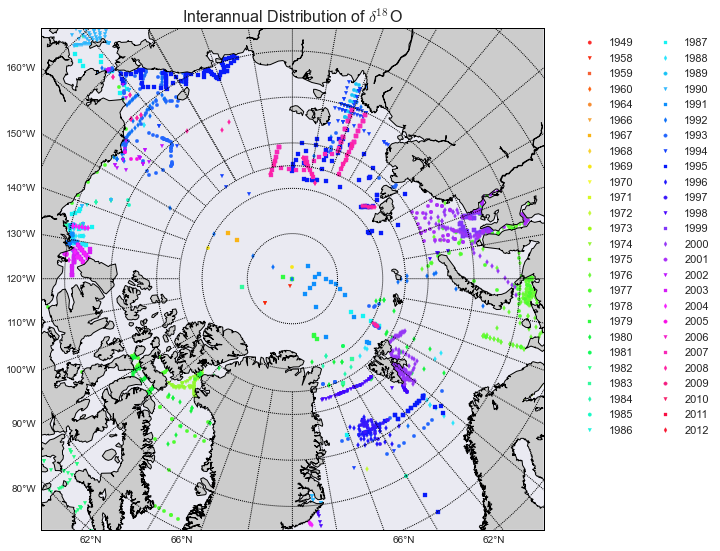

In [11]:
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness   = (50 + np.random.rand() * 10) / 100.
        saturation  = (90 + np.random.rand() * 10) / 100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

def pltAnnual():
    plt.figure(figsize=(figX,figY))  
    map = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l')
    #map = Basemap(projection='mill', lat_0=0, lon_0=0)
    parallels = np.arange(-90.,90.,4.)
    meridians = np.arange(-180.,181.,10.)
    map.drawparallels(parallels,labels=[False,False,False,True])
    map.drawmeridians(meridians,labels=[True,False,False,False])
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    #map.bluemarble()
    
    querryA =df[df.year!=-999]
    annie   =  querryA.year.unique()
    annie.sort()
    annieHall = len(annie)
    
    colorSwatch=_get_colors(annieHall)
    mark = ['o','v','s','d']        # pool of shapes for scatter    
    
    for i in range(annieHall):
        annualDF = df.loc[df.year==annie[i]]
        annualDF = annualDF[annualDF.depth<=10]
        
        x1 = annualDF.lon.values.T.tolist()
        y1 = annualDF.lat.values.T.tolist()
        x, y = map(x1, y1)
        
        map.scatter(x, y, marker=mark[i%4],color=colorSwatch[i],
                    label=annie[i],s=markScat)
    art = []
    lgd = plt.legend(loc='upper center',scatterpoints=1,ncol=2,
         bbox_to_anchor=(1.2, 1.0),prop={'size':11})
    plt.title('Interannual Distribution of $\delta^{18}$O',fontsize=titleS)
    #if(save == 1):
        #plt.savefig('interannual', dpi = 300)
    plt.show() 
pltAnnual()

Much of this interannual variability can be examined by looking at resources available from the <a href='http://www.nsidc.org/'>National Snow and Ice Data Center</a>... Particularly the minumum Sea Ice Cover in (which typically occurs in September).

## 2.4 Study Distribution <a id='2.4'></a>##
The database can be plotted by unique refence too.
<br><a href='#h'>Top</a><br>

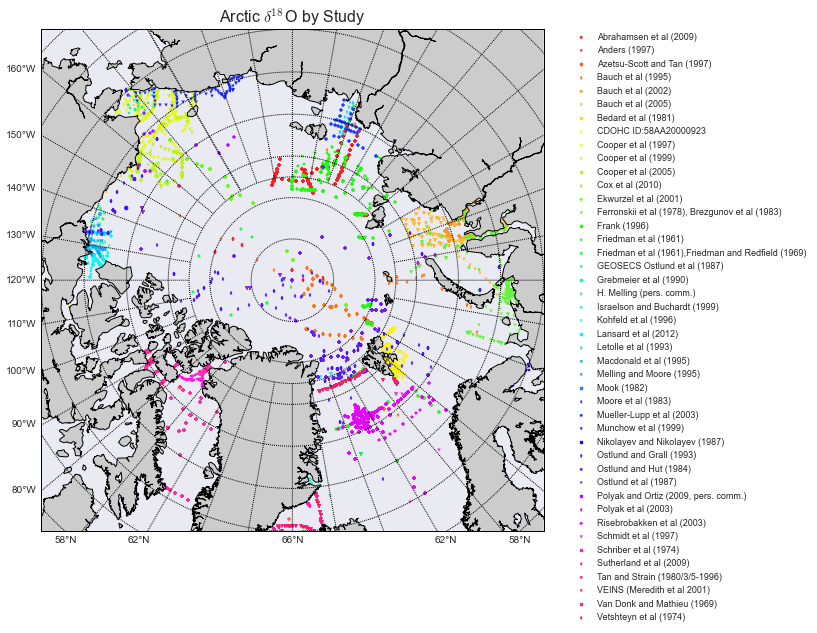

In [12]:
def pltRef():
    refList = df.ref.unique()       # creates list of unique references from DB
    refSize = refList.size          # how large is the list?
    
    colorSwatch=_get_colors(refSize)# get enough colors for each point. 
    mark = ['o','v','s','d']        # pool of shapes for scatter
    
    plt.figure(figsize=(10,10))     # initiate plot w/ dimensions.
    map = Basemap(projection='robin', lat_0=0, lon_0=0)
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    
    for i in range(0,refSize):
        #breaks dataframe into subdataframes of unique references    
        uniqueRef=refList[i]
        dfSub=df.loc[df['ref']==uniqueRef]
        x1 = dfSub.lon.values.T.tolist()    # convert longitude values to list
        y1 = dfSub.lat.values.T.tolist()    # convert latitude valus to list
        x, y = map(x1, y1)                  # convert the lon and lat into map
        map.scatter(x, y, marker=mark[i%4],color=colorSwatch[i],
                    label=str(refList[i]),s=3)
    art = []
    #lgd = plt.legend(scatterpoints=1,bbox_to_anchor=(1.05, 1), 
                     #loc=2, borderaxespad=0.0,prop={'size':8})
#    art.append(lgd)     
   
    plt.title(r'Global Observed $\delta18O$ by Study')
    plt.show
    #if (save == 1):
        #plt.savefig('observedD18O.png', bbox_inches="tight",
                    #additional_artists=art,format='png',dpi = 300)

"""****************************************************************************
Use this to generate a scatter plot for all arctic points by unique reference.
****************************************************************************""" 
def pltArcRef():
    # Define the Arctic...
    newArc = df.loc[df.lat>=65.8]
    refList = newArc.ref.unique()
    refList.sort()
    refSize = refList.size

    # Various Schemes of getting colors
    colorSwatch=_get_colors(refSize)
    
    mark = ['o','v','s','d']
    
    plt.figure(figsize=(figX,figY))
    map = Basemap(projection='npstere',boundinglat=66,lon_0=330,resolution='l')
    parallels = np.arange(-90.,90.,4.)
    meridians = np.arange(-180.,181.,10.)
    map.drawparallels(parallels,labels=[False,False,False,True])
    map.drawmeridians(meridians,labels=[True,False,False,False])
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()
    
    # Make a plot according to reference
    for i in range(0,refSize):
        #breaks dataframe into subdataframes of unique references    
        uniqueRef=refList[i]
        dfSub=newArc.loc[newArc['ref']==uniqueRef]
        x1 = dfSub.lon.values.T.tolist()    # convert longitude values to list
        y1 = dfSub.lat.values.T.tolist()    # convert latitude valus to list
        x, y = map(x1, y1)
        map.scatter(x, y, marker=mark[i%4],color=colorSwatch[i],label=str(uniqueRef),s=7)
    art = []
    lgd = plt.legend(ncol=1,scatterpoints=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0,prop={'size':9})
    art.append(lgd)    
    plt.title(r'Arctic $\delta^{18}$O by Study',size=titleS)
    #if (save == 1):
#       plt.savefig('arcDist.eps', format='eps', dpi=1000) #for vectors
    plt.show
pltArcRef()

# 3 Reigonal Partioning in the Arctic Ocean<a id='3'></a> #
After we've explored the spatio-temporal trends of the database, we can explore the reigonal δ18O-Sal relationships of each water mass. To do this, each reigon is distinguished by a specific two-digit ID on a 1x1 global grid in 3 "WOAMASK" .prn files. In this example, the Arctic Ocean is partitioned into 11 distinct water masses with the lat and lon coordinates recorded while running the <a href="https://github.com/yinleon/NASA/blob/master/grid_d18o_7_9_15.f">grid_d18o_7_9_15.f</a> Fortran script. The Fortran script not only calculates the Global Gridded Dataset see: <a href="http://pubs.giss.nasa.gov/abs/le09100s.html">[<i>LeGrande and Schmidt</i> 2006]</a>, but also partitions each of the 11 Arctic Water masses.
<br><a href='#h'>Top</a><br>

Distinct water masses are partitioned based on surface currents (Brown et al, 2001), geography and observational clusters (divided based on study). The coloring for the water masses (below) will remain consistent throughout our data analysis examples.

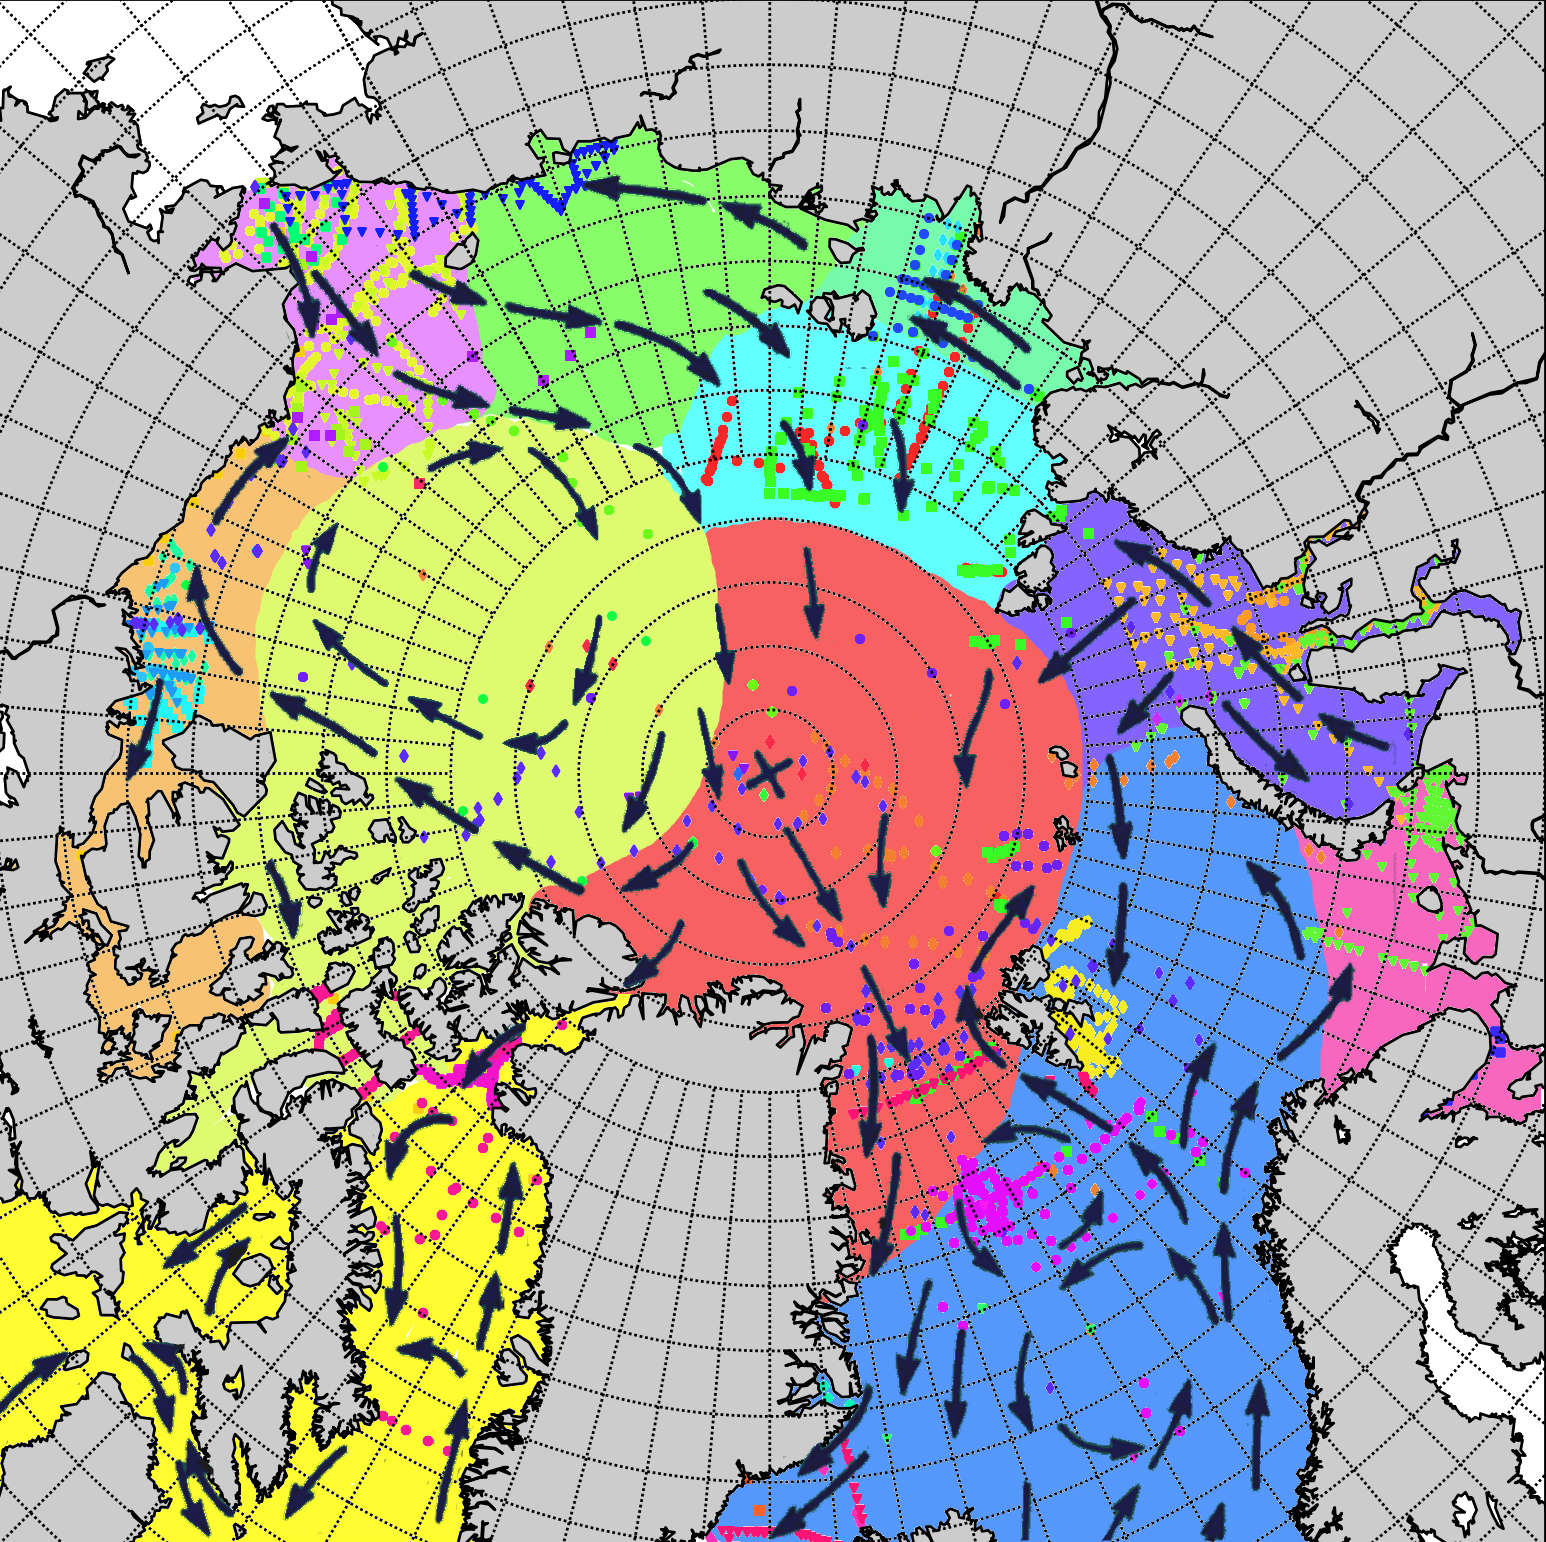

In [13]:
Image(filename='zones.jpg') 

With these distinctions we can map the water masses using a .prn mask and parse the database into reigons.

In [14]:
# Lon and Lat coordinates (as integers) derived from LeonArcMask.prn in grid_d18o_7_9_15
beauLonIN   =   'beauLon.txt'
beauLatIN   =   'beauLat.txt'
canLonIN    =   'canLon.txt'
canLatIN    =   'canLat.txt'
sibLonIN    =   'sibLon.txt'
sibLatIN    =   'sibLat.txt'
eurLonIN    =   'eurLon.txt'
eurLatIN    =   'eurLat.txt'
karLonIN    =   'karLon.txt'
karLatIN    =   'karLat.txt'
lapLonIN    =   'lapLon.txt'
lapLatIN    =   'lapLat.txt'
lomLonIN    =   'lomLon.txt'
lomLatIN    =   'lomLat.txt'
norLonIN    =   'norLon.txt'
norLatIN    =   'norLat.txt'
barLonIN    =   'barLon.txt'
barLatIN    =   'barLat.txt'
chukLonIN   =   'chukLon.txt'
chukLatIN   =   'chukLat.txt'

# Open the files containing the coordinates of each water mass
if(os.path.isfile(beauLonIN)):
    beauLonF    =   open(beauLonIN,"r")
else:
    print beauLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(beauLatIN)):
    beauLatF    =   open(beauLatIN,"r")
else:
    print beauLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(canLonIN)):
    canLonF    =   open(canLonIN,"r")
else:
    print canLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(canLatIN)):
    canLatF    =   open(canLatIN,"r")
else:
    print canLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(sibLonIN)):
    sibLonF    =   open(sibLonIN,"r")
else:
    print sibLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(sibLatIN)):
    sibLatF    =   open(sibLatIN,"r")
else:
    print sibLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(eurLonIN)):
    eurLonF    =   open(eurLonIN,"r")
else:
    print eurLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(eurLatIN)):
    eurLatF    =   open(eurLatIN,"r")
else:
    print eurLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(karLonIN)):
    karLonF    =   open(karLonIN,"r")
else:
    print karLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(karLatIN)):
    karLatF    =   open(karLatIN,"r")
else:
    print karLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(lapLonIN)):
    lapLonF    =   open(lapLonIN,"r")
else:
    print lapLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(lapLatIN)):
    lapLatF    =   open(lapLatIN,"r")
else:
    print lapLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(lomLonIN)):
    lomLonF    =   open(lomLonIN,"r")
else:
    print lomLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(lomLatIN)):
    lomLatF    =   open(lomLatIN,"r")
else:
    print lomLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(norLonIN)):
    norLonF    =   open(norLonIN,"r")
else:
    print norLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(norLatIN)):
    norLatF    =   open(norLatIN,"r")
else:
    print norLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(barLonIN)):
    barLonF    =   open(barLonIN,"r")
else:
    print barLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(barLatIN)):
    barLatF    =   open(barLatIN,"r")
else:
    print barLonIN,"is either unreadable or DNE."
    raise SystemExit
if(os.path.isfile(chukLonIN)):
    chukLonF    =   open(chukLonIN,"r")
else:
    print chukLonIN,"is either unreadable or DNE."
    raise SystemExit(0)
if(os.path.isfile(chukLatIN)):
    chukLatF    =   open(chukLatIN,"r")
else:
    print chukLonIN,"is either unreadable or DNE."
    raise SystemExit

# Parse file into a list
beauLat     =   beauLatF.read().split('\n')
beauLon     =   beauLonF.read().split('\n')
canLat      =   canLatF.read().split('\n')
canLon      =   canLonF.read().split('\n')
sibLat      =   sibLatF.read().split('\n')
sibLon      =   sibLonF.read().split('\n')
eurLat      =   eurLatF.read().split('\n')
eurLon      =   eurLonF.read().split('\n')
lapLat      =   lapLatF.read().split('\n')
lapLon      =   lapLonF.read().split('\n')
lomLat      =   lomLatF.read().split('\n')
lomLon      =   lomLonF.read().split('\n')
norLat      =   norLatF.read().split('\n')
norLon      =   norLonF.read().split('\n')
karLat      =   karLatF.read().split('\n')
karLon      =   karLonF.read().split('\n')
barLat      =   barLatF.read().split('\n')
barLon      =   barLonF.read().split('\n')
chukLat     =   chukLatF.read().split('\n')
chukLon     =   chukLonF.read().split('\n')

# Trim each array for the inevitable empty last index
beauLat     =   beauLat[:len(beauLat)-1]
beauLon     =   beauLon[:len(beauLon)-1]
canLat      =   canLat[:len(canLat)-1]
canLon      =   canLon[:len(canLon)-1]
sibLat      =   sibLat[:len(sibLat)-1]
sibLon      =   sibLon[:len(sibLon)-1]
eurLat      =   eurLat[:len(eurLat)-1]
eurLon      =   eurLon[:len(eurLon)-1]
lapLat      =   lapLat[:len(lapLat)-1]
lapLon      =   lapLon[:len(lapLon)-1]
lomLat      =   lomLat[:len(lomLat)-1]
lomLon      =   lomLon[:len(lomLon)-1]
norLat      =   norLat[:len(norLat)-1]
norLon      =   norLon[:len(norLon)-1]
karLat      =   karLat[:len(karLat)-1]
karLon      =   karLon[:len(karLon)-1]
barLat      =   barLat[:len(barLat)-1]
barLon      =   barLon[:len(barLon)-1]
chukLat     =   chukLat[:len(chukLat)-1]
chukLon     =   chukLon[:len(chukLon)-1]

# get the size of the list
beauPts     =   len(beauLon)
canPts      =   len(canLon)
sibPts      =   len(sibLon)
eurPts      =   len(eurLon)
lapPts      =   len(lapLon)
lomPts      =   len(lomLon)
norPts      =   len(norLon)
karPts      =   len(karLon)
barPts      =   len(barLon)
chukPts     =   len(chukLon)
arcticSum   =   beauPts+canPts+sibPts+eurPts+lapPts+lomPts+norPts+karPts+barPts+chukPts

"""****************************************************************************
Convert the read coordinates to integers that have the 
off one index for Python.
****************************************************************************"""
for i in range(0,beauPts):
    beauLat[i]=int(float(beauLat[i].strip()))-1
    beauLon[i]=int(float(beauLon[i].strip()))-1
for i in range(0,canPts):
    canLat[i]=int(float(canLat[i].strip()))-1
    canLon[i]=int(float(canLon[i].strip()))-1
for i in range(0,sibPts):
    sibLat[i]=int(float(sibLat[i].strip()))-1
    sibLon[i]=int(float(sibLon[i].strip()))-1
for i in range(0,eurPts):
    eurLat[i]=int(float(eurLat[i].strip()))-1
    eurLon[i]=int(float(eurLon[i].strip()))-1
for i in range(0,lapPts):
    lapLat[i]=int(float(lapLat[i].strip()))-1
    lapLon[i]=int(float(lapLon[i].strip()))-1
for i in range(0,lomPts):
    lomLat[i]=int(float(lomLat[i].strip()))-1
    lomLon[i]=int(float(lomLon[i].strip()))-1
for i in range(0,norPts):
    norLat[i]=int(float(norLat[i].strip()))-1
    norLon[i]=int(float(norLon[i].strip()))-1
for i in range(0,karPts):
    karLat[i]=int(float(karLat[i].strip()))-1
    karLon[i]=int(float(karLon[i].strip()))-1
for i in range(0,barPts):
    barLat[i]=int(float(barLat[i].strip()))-1
    barLon[i]=int(float(barLon[i].strip()))-1
for i in range(0,chukPts):
    chukLat[i]=int(float(chukLat[i].strip()))-1
    chukLon[i]=int(float(chukLon[i].strip()))-1
"""****************************************************************************
Search the database for coordinates in each reigon and parase those records 
into subDFs. Lists of references are avaiable to view and download.
****************************************************************************"""
# Convert the DB lat and lon to integers...
df.lon = df.lon.astype(int)
df.lat = df.lat.astype(int)

# Search the DB for Beaufort sea coordiantes, starting with lat then lon.
beauDF = df.loc[df.lat==beauLat[0]-89]           # create a subDF for each reigon starting with Lat.
beauDF = beauDF.loc[beauDF.lon==beauLon[0]-179]  # hone in with Lon!
for i in range(1,beauPts):
    # Make each coordinate of the arctic a unique dataframe.
    beauT  = df.loc[df.lat==beauLat[i]-89]         # create a temp DF for specific reigonal Lat.
    beauT  = beauT.loc[beauT.lon==beauLon[i]-179]  # within temp DF hone in on specific reigonal Lon.
    beauDF = beauDF.append(beauT)                  # Add the reigonal points to the Master.      
# Unique count and list of arctic refernces
beauRefList = beauDF.ref.unique()
beauRefSize = beauRefList.size

# We're going to do the exact same routine for each arctic reigon...
# Search the DB for Canadian basin coordiantes, starting with lat then lon.
canDF = df.loc[df.lat==canLat[0]-89]
canDF = canDF.loc[canDF.lon==canLon[0]-179]     
for i in range(1,canPts):
    canT  = df.loc[df.lat==canLat[i]-89]        
    canT  = canT.loc[canT.lon==canLon[i]-179]   
    canDF = canDF.append(canT)                        
# Unique count and list of arctic refernces
canRefList = canDF.ref.unique()
canRefSize = canRefList.size

# Search the DB for E siberian shelf coordiantes, starting with lat then lon.
sibDF = df.loc[df.lat==sibLat[0]-89]           
sibDF = sibDF.loc[sibDF.lon==sibLon[0]-179]      
for i in range(1,sibPts):
    sibT  = df.loc[df.lat==sibLat[i]-89]          
    sibT  = sibT.loc[sibT.lon==sibLon[i]-179]      
    sibDF = sibDF.append(sibT)                        
# Unique count and list of arctic refernces
sibRefList = sibDF.ref.unique()
sibRefSize = sibRefList.size

# Search the DB for eursian basin coordiantes, starting with lat then lon.
eurDF = df.loc[df.lat==eurLat[0]-89]         
eurDF = eurDF.loc[eurDF.lon==eurLon[0]-179]  
for i in range(1,eurPts):
    eurT  = df.loc[df.lat==eurLat[i]-89]         
    eurT  = eurT.loc[eurT.lon==eurLon[i]-179]  
    eurDF = eurDF.append(eurT)                     
# Unique count and list of arctic refernces
eurRefList = eurDF.ref.unique()
eurRefSize = eurRefList.size

lapDF = df.loc[df.lat==lapLat[0]-89]         # create a subDF for each reigon starting with Lat.
lapDF = lapDF.loc[lapDF.lon==lapLon[0]-179]  # hone in with Lon!
for i in range(1,lapPts):
    # Make each coordinate of the arctic a unique dataframe.
    lapT  = df.loc[df.lat==lapLat[i]-89]         # create a temp DF for specific reigonal Lat.
    lapT  = lapT.loc[lapT.lon==lapLon[i]-179]  # within temp DF hone in on specific reigonal Lon.
    lapDF = lapDF.append(lapT)                  # Add the reigonal points to the Master.      
# Unique count and list of arctic refernces
lapRefList = lapDF.ref.unique()
lapRefSize = lapRefList.size

# Search the DB for lomadian basin coordiantes, starting with lat then lon.
lomDF = df.loc[df.lat==lomLat[0]-89]
lomDF = lomDF.loc[lomDF.lon==lomLon[0]-179]     
for i in range(1,lomPts):
    lomT  = df.loc[df.lat==lomLat[i]-89]        
    lomT  = lomT.loc[lomT.lon==lomLon[i]-179]   
    lomDF = lomDF.append(lomT)                        
# Unique count and list of arctic refernces
lomRefList = lomDF.ref.unique()
lomRefSize = lomRefList.size

# Search the DB for E norerian shelf coordiantes, starting with lat then lon.
norDF = df.loc[df.lat==norLat[0]-89]           
norDF = norDF.loc[norDF.lon==norLon[0]-179]      
for i in range(1,norPts):
    norT  = df.loc[df.lat==norLat[i]-89]          
    norT  = norT.loc[norT.lon==norLon[i]-179]      
    norDF = norDF.append(norT)                        
# Unique count and list of arctic refernces
norRefList = norDF.ref.unique()
norRefSize = norRefList.size

# Search the DB for karsian basin coordiantes, starting with lat then lon.
karDF = df.loc[df.lat==karLat[0]-89]         
karDF = karDF.loc[karDF.lon==karLon[0]-179]  
for i in range(1,karPts):
    karT  = df.loc[df.lat==karLat[i]-89]         
    karT  = karT.loc[karT.lon==karLon[i]-179]  
    karDF = karDF.append(karT)                     
# Unique count and list of arctic refernces
karRefList = karDF.ref.unique()
karRefSize = karRefList.size

# Search the DB for E chukerian shelf coordiantes, starting with lat then lon.
chukDF = df.loc[df.lat==chukLat[0]-89]           
chukDF = chukDF.loc[chukDF.lon==chukLon[0]-179]      
for i in range(1,chukPts):
    chukT  = df.loc[df.lat==chukLat[i]-89]          
    chukT  = chukT.loc[chukT.lon==chukLon[i]-179]      
    chukDF = chukDF.append(chukT)                        
# Unique count and list of arctic refernces
chukRefList = chukDF.ref.unique()
chukRefSize = chukRefList.size

# Search the DB for barsian basin coordiantes, starting with lat then lon.
barDF = df.loc[df.lat==barLat[0]-89]         
barDF = barDF.loc[barDF.lon==barLon[0]-179]  
for i in range(1,barPts):
    barT  = df.loc[df.lat==barLat[i]-89]         
    barT  = barT.loc[barT.lon==barLon[i]-179]  
    barDF = barDF.append(barT)                     
# Unique count and list of arctic refernces
barRefList = barDF.ref.unique()
barRefSize = barRefList.size

# Statistics per reigon
print "There are",beauRefSize,"references to the Beaufort Sea from",\
len(beauDF.index),"unique points.\
\nWith a temporal distribution of",len(beauDF.month.unique()),"months and",len(beauDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",canRefSize,"references to the Canadian Basin from",\
len(canDF.index),"unique points.\
\nWith a temporal distribution of",len(canDF.month.unique()),"months and",len(canDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",sibRefSize,"references to the E Siberian Shelf from",\
len(sibDF.index),"unique points.\
\nWith a temporal distribution of",len(sibDF.month.unique()),"months and",len(sibDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",eurRefSize,"references to the Eursian Basin from",\
len(eurDF.index),"unique points.\
\nWith a temporal distribution of",len(eurDF.month.unique()),"months and",len(eurDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",lapRefSize,"references to the Laplev Sea from",\
len(lapDF.index),"unique points.\
\nWith a temporal distribution of",len(lapDF.month.unique()),"months and",len(lapDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",lomRefSize,"references to the Lomonosov Ridge from",\
len(lomDF.index),"unique points.\
\nWith a temporal distribution of",len(lomDF.month.unique()),"months and",len(lomDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",norRefSize,"references to the Norweigian Sea from",\
len(norDF.index),"unique points.\
\nWith a temporal distribution of",len(norDF.month.unique()),"months and",len(norDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",karRefSize,"references to the Kara Sea from",\
len(karDF.index),"unique points.\
\nWith a temporal distribution of",len(karDF.month.unique()),"months and",len(karDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",chukRefSize,"references to the Chukchi Sea from",\
len(chukDF.index),"unique points.\
\nWith a temporal distribution of",len(chukDF.month.unique()),"months and",len(chukDF.year.unique()),"years..."
print"--------------------------------------------------------------------"
print "There are",barRefSize,"references to the Barents Sea from",\
len(barDF.index),"unique points.\
\nWith a temporal distribution of",len(barDF.month.unique()),"months and",len(barDF.year.unique()),"years..."
print"--------------------------------------------------------------------"

# Final stats
arcMaster   =   eurDF.append(sibDF).append(canDF).append(beauDF).append(lapDF)\
                .append(lomDF).append(norDF).append(karDF).append(chukDF).append(barDF)
arcRef      =   arcMaster.ref.unique()
arcRefSize  =   arcRef.size

print"\nThere are",len(arcMaster.index),"unique coordinate points in the arctic."
print"There are",arcRefSize,"refs that can be viewed by typing arcRef into the shell."

# Revive DB! back to .00 percision from 0. percision   
df=pd.read_fwf(filein,widths=fWid,header=None,names=col,skip_blank_lines=True) 
for i in range(0,files2Add):
    csv2DF=pd.read_csv(toAdd[i],sep=',',skiprows=1,names=col,na_filter=True)
    dfRows= len(df.index-1)
    df = df.append(csv2DF)     # add the contents of new csv into DB.
    dfRows= len(df.index-1)    # update the number of records in the DB.

There are 12 references to the Beaufort Sea from 529 unique points.
With a temporal distribution of 9 months and 13 years...
--------------------------------------------------------------------
There are 8 references to the Canadian Basin from 256 unique points.
With a temporal distribution of 9 months and 13 years...
--------------------------------------------------------------------
There are 4 references to the E Siberian Shelf from 131 unique points.
With a temporal distribution of 3 months and 4 years...
--------------------------------------------------------------------
There are 12 references to the Eursian Basin from 1021 unique points.
With a temporal distribution of 9 months and 18 years...
--------------------------------------------------------------------
There are 4 references to the Laplev Sea from 295 unique points.
With a temporal distribution of 3 months and 6 years...
--------------------------------------------------------------------
There are 4 references to the

## 4 Statistical Analysis <a id='4'></a>#
Now that the computer can understand how we've partitioned the Arctic Ocean, we can start on the statistical analysis.
To get a baseline, let's compare the observed salinity to the averaged monthly salinity.
<br><a href='#h'>Top</a><br>

/Users/leonyin/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


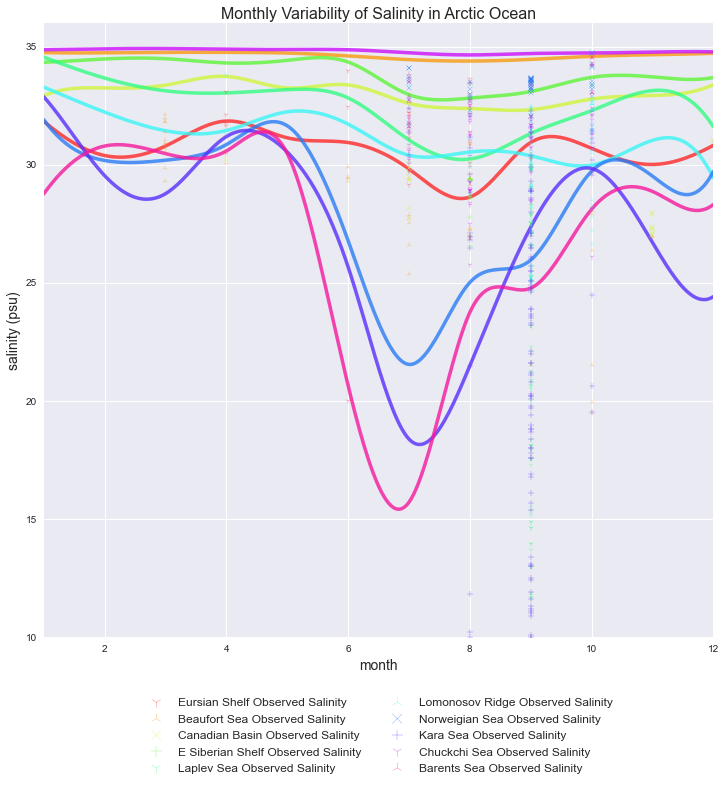

In [15]:
# Open World Ocean Atlas 2001 to extract monthly salinity
if(os.path.isfile(WOAF)):
    WOA    =   Dataset(WOAF, mode='r')
else:
    print WOA,"is either unreadable or DNE."
    raise SystemExit
# Looking at the netCDF surface lvl 0 where: sal[month][depth][Lat][Lon]
sal =WOA.variables['salinity'][:,0,:,:]

beauSalAv   =   (np.zeros(12))
canSalAv    =   (np.zeros(12))
sibSalAv    =   (np.zeros(12))
eurSalAv    =   (np.zeros(12))
lapSalAv    =   (np.zeros(12))
lomSalAv    =   (np.zeros(12))
norSalAv    =   (np.zeros(12))
karSalAv    =   (np.zeros(12))
barSalAv    =   (np.zeros(12))
chukSalAv   =   (np.zeros(12))
# Calculate monthly average Salinity per reigon
for month in range(0,12):
    beauSal=np.zeros(beauPts)
    for i in range(0,beauPts):
        beauSal[i]=sal[month][beauLat[i]][beauLon[i]]
    #mask the nan values and calculated the average of sal
    beauSal=np.ma.masked_invalid(beauSal)
    beauSalAv[month]=round(np.ma.mean(beauSal),2)

    canSal=np.zeros(canPts)
    for i in range(0,canPts):
        canSal[i]=sal[month][canLat[i]][canLon[i]]
    #mask the nan values and calculated the average of sal
    canSal=np.ma.masked_invalid(canSal)
    canSalAv[month]=round(np.ma.mean(canSal),2)

    sibSal=np.zeros(sibPts)
    for i in range(0,sibPts):
        sibSal[i]=sal[month][sibLat[i]][sibLon[i]]
    #mask the nan values and calculated the average of sal
    sibSal=np.ma.masked_invalid(sibSal)
    sibSalAv[month]=round(np.ma.mean(sibSal),2)

    eurSal=np.zeros(eurPts)
    for i in range(0,eurPts):
        eurSal[i]=sal[month][eurLat[i]][eurLon[i]]
    #mask the nan values and calculated the average of sal
    eurSal=np.ma.masked_invalid(eurSal)
    eurSalAv[month]=round(np.ma.mean(eurSal),2)

    lapSal=np.zeros(lapPts)
    for i in range(0,lapPts):
        lapSal[i]=sal[month][lapLat[i]][lapLon[i]]
    #mask the nan values and calculated the average of sal
    lapSal=np.ma.masked_invalid(lapSal)
    lapSalAv[month]=round(np.ma.mean(lapSal),2)

    lomSal=np.zeros(lomPts)
    for i in range(0,lomPts):
        lomSal[i]=sal[month][lomLat[i]][lomLon[i]]
    #mask the nan values and calculated the average of sal
    lomSal=np.ma.masked_invalid(lomSal)
    lomSalAv[month]=round(np.ma.mean(lomSal),2)

    norSal=np.zeros(norPts)
    for i in range(0,norPts):
        norSal[i]=sal[month][norLat[i]][norLon[i]]
    #mask the nan values and calculated the average of sal
    norSal=np.ma.masked_invalid(norSal)
    norSalAv[month]=round(np.ma.mean(norSal),2)

    karSal=np.zeros(karPts)
    for i in range(0,karPts):
        karSal[i]=sal[month][karLat[i]][karLon[i]]
    #mask the nan values and calculated the average of sal
    karSal=np.ma.masked_invalid(karSal)
    karSalAv[month]=round(np.ma.mean(karSal),2)

    barSal=np.zeros(barPts)
    for i in range(0,barPts):
        barSal[i]=sal[month][barLat[i]][barLon[i]]
    #mask the nan values and calculated the average of sal
    barSal=np.ma.masked_invalid(barSal)
    barSalAv[month]=round(np.ma.mean(barSal),2)

    chukSal=np.zeros(chukPts)
    for i in range(0,chukPts):
        chukSal[i]=sal[month][chukLat[i]][chukLon[i]]
    #mask the nan values and calculated the average of sal
    chukSal=np.ma.masked_invalid(chukSal)
    chukSalAv[month]=round(np.ma.mean(chukSal),2)


y1List = (eurSalAv,beauSalAv,canSalAv,sibSalAv,lapSalAv,lomSalAv,
                 norSalAv,karSalAv,chukSalAv,barSalAv)

# The above routine can be nested into the function below...

def pltSal():
    # Plot
    fig = plt.figure(figsize=(12,11))     
    ax1 = fig.add_subplot(111)                              
    
    ax1.set_ylabel('salinity (psu)',size=14)
    ax1.set_xlabel('month',size=14)
    
    ax1.set_xlim((1,12))
    ax1.set_ylim(10,36)

    for i in range(0,reigons):
        # points on the surface of the first (surfDep) meters
        arcSurf=DFList[i].loc[DFList[i].depth<surfDep]        
        # remove the -99.90 (skip values) from the Db salinity.
        arcSurf=arcSurf[arcSurf.sal!=skip]
        arcSurf=arcSurf[arcSurf.d18o!=skip]
        arcSurf=arcSurf[arcSurf.month!=13]
        
        # plotting parameters
        ySal    =   arcSurf.sal
        xArc    =   arcSurf.month # month coordiantes per reigon
        y1      =   y1List[i]
        x1      =   np.array([1,2,3,4,5,6,7,8,9,10,11,12])
        xMonSp  =   np.linspace(x1.min(),x1.max(),300)
        ySalSp  =   spline(x1,y1, xMonSp)
        yD18O   =   arcSurf.d18o
        # plot the monthly average salinity
        ax1.plot(xMonSp,ySalSp ,linewidth=linWid,color=colorSwatch[i],zorder=1,alpha=.8)
        # plot the observed salinity
        ax1.scatter(xArc ,ySal ,marker=markSal[i%4],s=sizeSal[i%4],
                    color=colorSwatch[i],label=lblSal[i],alpha=.9,zorder=10)
    
    art = []
    lgd = ax1.legend(scatterpoints=1,loc='upper center',markerscale=2,
                     bbox_to_anchor=(0.5, -0.08),ncol=2,prop={'size':12})
    art.append(lgd) 

    plt.title('Monthly Variability of Salinity in Arctic Ocean',size=16)
    #if (save == 1):
        #plt.savefig('salDistro.png',additional_artists=art,bbox_inches="tight", dpi=300)
    plt.show

# Some parameters before plotting
DFList      =   (eurDF,beauDF,canDF,sibDF,lapDF,lomDF,norDF,karDF,chukDF,barDF)

reigonName  =   ('Eurasian Basin','Beaufort Sea','Canadian Basin','E Siberian Shelf','Laplev Sea'
                ,'Lomonosov Ridge','Norweigian Sea','Kara Sea','Chukchi Sea','Barents Sea')

reigons     =   len(DFList)

lblSal      =     ('Eursian Shelf Observed Salinity ','Beaufort Sea Observed Salinity ',
                   'Canadian Basin Observed Salinity','E Siberian Shelf Observed Salinity '
                 ,'Laplev Sea Observed Salinity ','Lomonosov Ridge Observed Salinity ',
                 'Norweigian Sea Observed Salinity','Kara Sea Observed Salinity '
                 ,'Chuckchi Sea Observed Salinity ','Barents Sea Observed Salinity ')
                          
lblD18      =   ('Eursian Shelf $\delta$18O','Beaufort Sea $\delta$18O','Canadian Basin $\delta$18O',
                 'E Siberian Shelf $\delta$18O','Laptev Sea $\delta$18O','Lomonosov Ridge $\delta$18O',
                 'Norweigian Sea $\delta$18O','Kara Sea $\delta$18O','Chuckchi Sea $\delta$18O','Barents Sea $\delta$18O')

colorSwatch =   _get_colors(reigons)

markSal     =   ('1','2','x','+')
markD18     =   ('o','p','d','v')
sizeSal     =   (28,28,24,28) # change this when not viewing on iPython...
sizeD18     =   (14,18,14,12) # change this when not viewing on iPython...

# run it!
pltSal()

## 4.1 Monthly Salinity and δO<sup>18</sup> Variability <a id='4.1'></a>##
To get a bit of more insight, we can add another axis for δO<sup>18</sup> to see the relationship between the two fields and how they vary from month to month.
<br><a href='#h'>Top</a><br>

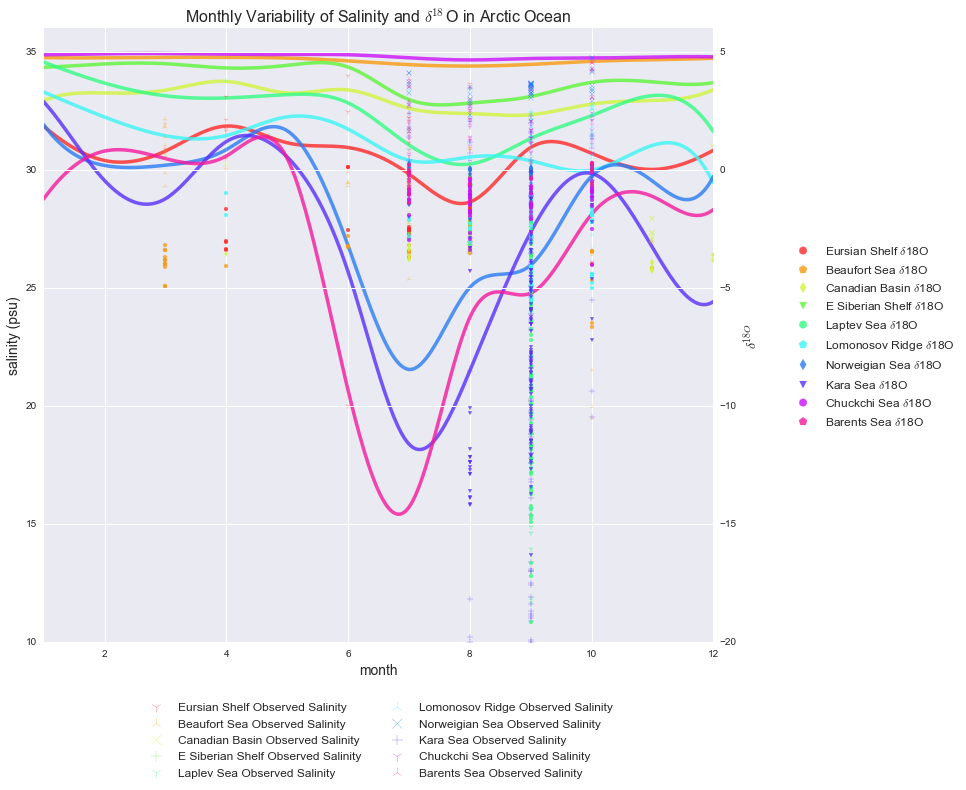

In [16]:
def pltSal_dO18():
    fig = plt.figure(figsize=(12,11))     
    ax1 = fig.add_subplot(111)                              
    
    ax2=ax1.twinx()
    ax1.set_ylabel('salinity (psu)',size=14)
    ax1.set_xlabel('month',size=14)
    ax2.set_ylabel('$\delta^{18O}$',size=14)
    
    ax1.set_xlim((1,12))
    ax1.set_ylim(10,36)
    ax2.set_xlim((1,12))
    ax2.set_ylim((-20,6))
    
    for i in range(0,reigons):
        # points on the surface of the first (surfDep) meters
        arcSurf=DFList[i].loc[DFList[i].depth<surfDep]        
        # remove the -99.90 (skip values) from the Db salinity.
        arcSurf=arcSurf[arcSurf.sal!=skip]
        arcSurf=arcSurf[arcSurf.d18o!=skip]
        arcSurf=arcSurf[arcSurf.month!=13]
        
        # plotting parameters
        ySal    =   arcSurf.sal
        xArc    =   arcSurf.month # month coordiantes per reigon
        y1      =   y1List[i]
        x1      =   np.array([1,2,3,4,5,6,7,8,9,10,11,12])
        xMonSp  =   np.linspace(x1.min(),x1.max(),300)
        ySalSp  =   spline(x1,y1, xMonSp)
        yD18O   =   arcSurf.d18o
        # plot the monthly average salinity
        ax1.plot(xMonSp,ySalSp ,linewidth=linWid,color=colorSwatch[i],zorder=1,alpha=.8)
        # plot the observed salinity
        ax1.scatter(xArc ,ySal ,marker=markSal[i%4],s=sizeSal[i%4],
                    color=colorSwatch[i],label=lblSal[i],alpha=.9,zorder=10)
        # plot the observed d18O
        ax2.scatter(xArc ,yD18O,marker=markD18[i%4],s=sizeD18[i%4],
                    color=colorSwatch[i],label=lblD18[i],alpha=.8,zorder=5)
    
    art = []
    lg2 = ax2.legend(scatterpoints=1,loc='center left',markerscale=2,
                     bbox_to_anchor=(1.1,.5),ncol=1,prop={'size':12})
    lgd = ax1.legend(scatterpoints=1,loc='upper center',markerscale=2,
                     bbox_to_anchor=(0.5, -0.08),ncol=2,prop={'size':12})
    art.append(lgd) 
    art.append(lg2)

    plt.title(r'Monthly Variability of Salinity and $\delta^{18}$O in Arctic Ocean',size=16)
    #if (save == 1):
        #plt.savefig('salDistro.png',additional_artists=art,bbox_inches="tight", dpi=300)
    plt.show
# run it!    
pltSal_dO18()

## 4.2 Reigonal Slope Analysis <a id='4.2'></a>
To assess unique and similar reigonal patterns, we can look at the relationship between salinity (crosses) and δ18O (polygons). Using linear slope regression we can find the freshwater origin (Y-int) and mixing path (Slope), which can provide some key insights to Arctic hydrology and ciruclation.
<br><a href='#h'>Top</a>

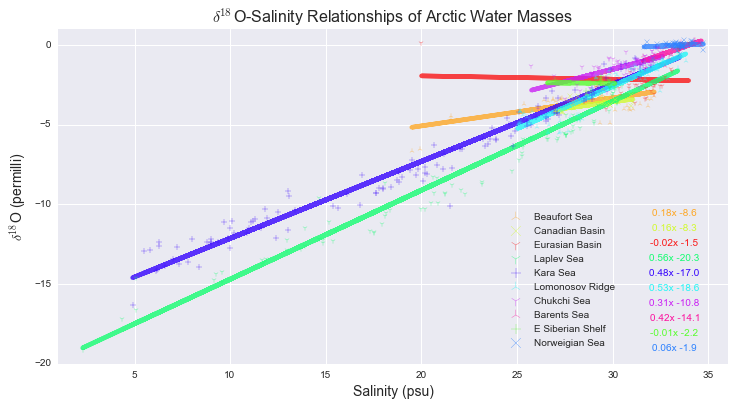

In [17]:
def pltD18O_sal():
    fig = plt.figure(figsize=(12,6))     
    ax = fig.add_subplot(111)    
    ax.set_ylabel('$\delta^{18}$O (permilli)',size=14)
    ax.set_xlabel('Salinity (psu)',size=14)
    ax.set_xlim((1,36))
    ax.set_ylim(-20,1)   
    colorSwatch=_get_colors(reigons)
    order = (1,2,0,4,7,5,8,9,3,6)

    for i in range(len(order)):
        # points on the surface of the first (surfDep) meters
        arcSurf=DFList[order[i]].loc[DFList[order[i]].depth<surfDep]
    
        # remove the -99.90 (skip values) from the Db salinity.
        arcSurf=arcSurf[arcSurf.sal!=skip]
        arcSurf=arcSurf[arcSurf.d18o!=skip]
        arcSurf=arcSurf[arcSurf.month!=13]
    
        # Calculate slope and y-int
        x = arcSurf.sal  #sal
        y = arcSurf.d18o #d18O        
    
        par = np.polyfit(x, y, 1, full=True)
        m=par[0][0]     # SLOPE
        b=par[0][1]     # Y-INTERCEPT
        # Put the average WOA salinity in smooth plot-able format.
        yp = np.polyval([m,b],x)
        # plotting
        ax.plot(x,yp,color=colorSwatch[order[i]],linewidth=4.5,alpha = .8,zorder=1)   
        ax.scatter(x ,y ,marker=markSal[order[i]%4],s=sizeSal[order[i]%4],\
                   color=colorSwatch[order[i]],label=reigonName[order[i]],
                    alpha=1,zorder=10)
        # the slope-intercept equation of each reigonal water body.
        equation=str(round(m,2))+"x "+str(round(b,1))  
        ax.text(.92, 0.45-(i*.045),equation,horizontalalignment='center',
                color=colorSwatch[order[i]], verticalalignment='center',
                 transform=ax.transAxes,size=10)
    art = []
    lgd = ax.legend(scatterpoints=1,markerscale=2, loc='center',
                    bbox_to_anchor=(.75,.25),ncol=1,prop={'size':10},frameon=False)
    art.append(lgd) 
    plt.title('$\delta^{18}$O-Salinity Relationships of Arctic Water Masses',size=titleS)
    #if (save == 1):
        #plt.savefig('slopes.png',additional_artists=art,bbox_inches="tight", dpi=300)
    plt.show
pltD18O_sal()

## 4.3 Jackknife Slope Analysis with Outlier Flagging <a id='4.3'></a>
These values should not be taken at face value until we scrutinize the data for anamolous, erroneous and conflicting data. To tease out some of these troublesome values we can employ Jackknife Slope Analysis- which calculates the reigonal δ18O-sal relationships (as above), to methodically flag outliers for inspection.
<br><a href='#h'>Top</a>

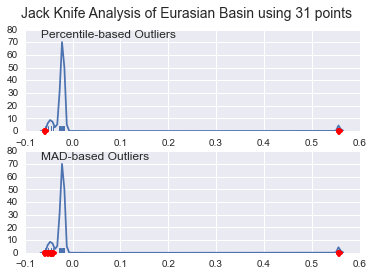

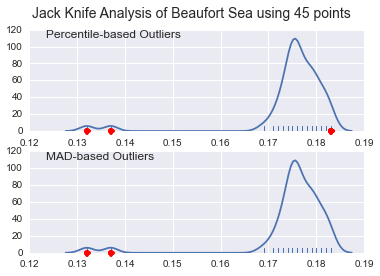

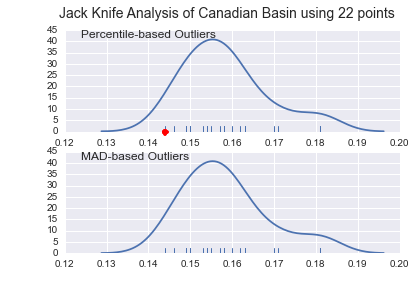

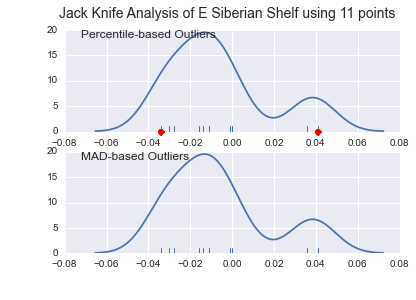

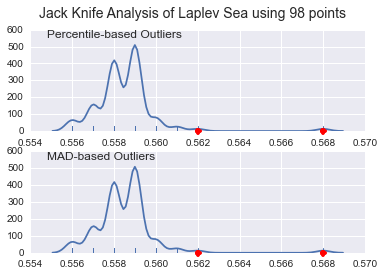

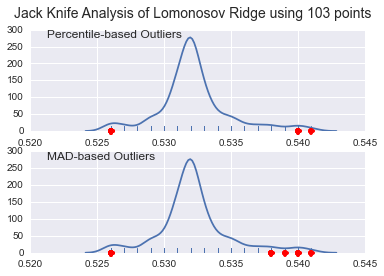

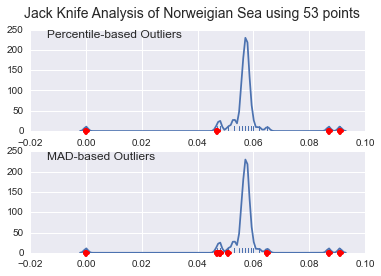

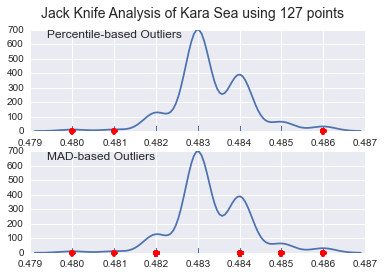

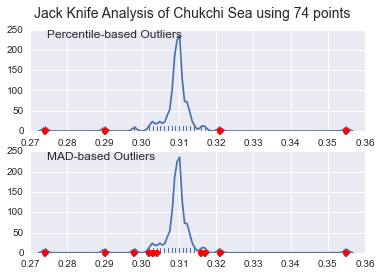

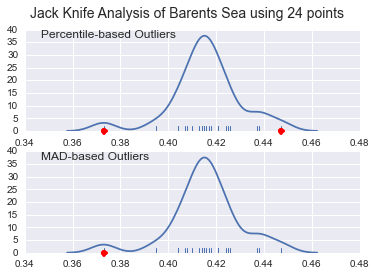

Eurasian Basin:
    id  sig    lat   lon  m    y  dep  temp   sal  d18o                           ref
 17892-0.05   0.00 81.00  9 1980    0 -1.80 33.48 -0.26        Ostlund and Hut (1984)
 18115-0.04   0.00 90.00 10 1978    0-99.90 29.67 -4.00        Ostlund and Hut (1984)
 18067 0.56   3.00 80.00  6 1984    0 -1.20 20.00  0.14       Ostlund and Grall (1993
 18039-0.06   6.00 81.00  6 1983    2 -1.65 33.97  0.12       Ostlund and Grall (1993
 15390-0.05  40.00 82.00  8 1993    9 -1.75 33.66  0.04                  Frank (1996)
   171-0.04  42.00 85.00  8 1991    5 -1.74 33.47 -0.29            Bauch et al (1995)
Beaufort Sea:
    id  sig    lat   lon  m    y  dep  temp   sal  d18o                           ref
 18346 0.13-141.00 71.00 10 1984    0 -1.17 19.49 -6.64       Ostlund and Grall (1993
 18347 0.14-141.00 71.00 10 1984    5 -1.10 19.94 -6.50       Ostlund and Grall (1993
Canadian Basin:
    id  sig    lat   lon  m    y  dep  temp   sal  d18o                           ref
E Siberi

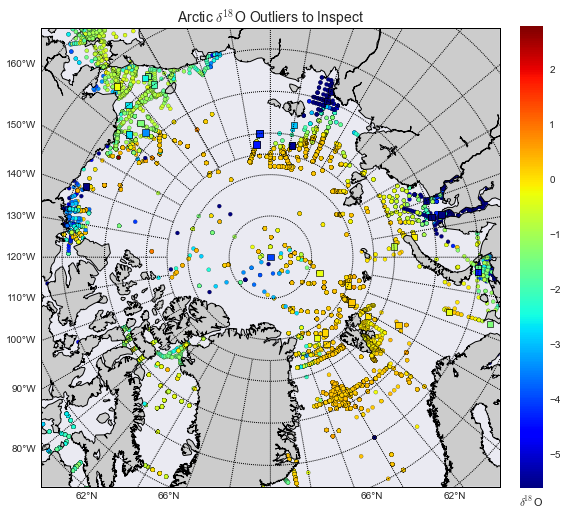

We should inspect these elements [squares], but we're only really concerned with measurements that greatly skew the slope...
Eurasian Basin:
    id  sig    lat   lon  m    y  dep  temp   sal  d18o                           ref
 18067 0.56   3.00 80.00  6 1984    0 -1.20 20.00  0.14      Ostlund and Grall (1993)


In [18]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# This function finds all outliers according to percentile, median average, and inputed(dev) deviation
def jackKnife(dev):
    import seaborn as sns
    # Initialize some empty lists...        
    outDF = pd.DataFrame(columns=col)
    indieList = [[] for i in range(reigons)]    
    jack = [[] for i in range(reigons)]
    outliers = [[] for i in range(reigons)]
    m = np.zeros(reigons)  
    b = np.zeros(reigons)   
    # iterate through each reigon...
    for i in range(reigons):
        # parse dataframe for correct reigon and depth
        arcSurf=DFList[i].loc[DFList[i].depth<surfDep]
        
        # remove the -99.90 (skip values) from the Db salinity.
        arcSurf=arcSurf[arcSurf.sal!=skip]
        arcSurf=arcSurf[arcSurf.d18o!=skip]
        arcSurf=arcSurf[arcSurf.month!=13]
        
        reigLen = len(arcSurf)
        jack[i] = np.zeros(reigLen)                        # empty list for each jack knife
        indieList[i] = arcSurf.index.values.T.tolist()     # list of all natural indicies per Reigon
        
        # Calculate slope and y-int for a Baseline Val...
        x = arcSurf.sal  #sal
        y = arcSurf.d18o #d18O        
        par = np.polyfit(x, y, 1, full=True)
        m[i]=par[0][0]     # SLOPE
        b[i]=par[0][1]     # Y-INTERCEPT
        # jacknife - calculate slope and y-intercept by methodically removing one value from the entire set.
        for j in range(reigLen): 
            temp = arcSurf[arcSurf.index!=indieList[i][j]] # remove one ID at a time
            x3 = temp.sal
            y3 = temp.d18o
            par2 = np.polyfit(x3, y3, 1, full=True)        # least squares
            m1=par2[0][0]           # SLOPE
            b1=par2[0][1]           # Y-INTERCEPT
            jack[i][j]=round(m1,3)  # Record jackknife with 3-decimal percision
            
        # Density distribution of jack knife and outliers
        fig, axes = plt.subplots(nrows=2)
        for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier]):
            sns.distplot(jack[i], ax=ax, rug=True, hist=False)
            outliers[i] = jack[i][func(jack[i])]
            ax.plot(outliers[i], np.zeros_like(outliers[i]), 'ro', clip_on=False)
            fig.suptitle('Jack Knife Analysis of '+reigonName[i]+' using {} points'.format(len(jack[i])), size=14)
        kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
        axes[0].set_title('Percentile-based Outliers', **kwargs)
        axes[1].set_title('MAD-based Outliers', **kwargs)
        #if (save == 1):
            #plt.savefig(reigonName[i]+'outliers.png') 
        plt.show()
    

    # Display complete info for outliers per reigon...
    for i in range(reigons):
        print reigonName[i]+":"
        
        # points on the surface of the first (surfDep) meters
        arcSurf=DFList[i].loc[DFList[i].depth<surfDep]
        
        # remove the -99.90 (skip values) from the Db salinity.
        arcSurf=arcSurf[arcSurf.sal!=skip]
        arcSurf=arcSurf[arcSurf.d18o!=skip]
        arcSurf=arcSurf[arcSurf.month!=13]
        
        print ( '{:>6}{:>5}{:>7}{:>6} {:>2} {:>4}{:>5}{:>6}{:>6}{:>6}{:>30}'\
            .format('id','sig','lat','lon','m','y','dep','temp','sal','d18o','ref'))
        # per outlier
        for j in range(len(outliers[i])):
            qq=np.where(jack[i]==outliers[i][j])                        # line up each outlier with location on reigonal index
            outRow = arcSurf.loc[arcSurf.index==indieList[i][qq[0][0]]] # match outlier with original DB
            v = outRow.values.T.tolist()                                # point to all outlier fields in list format
            print ( '{:>6.0f}{:>5.2f}{:>7.2f}{:>6.2f} {:>2.0f} {:>4.0f}{:>5.0f}{:6.2f}{:6.2f}{:6.2f}{:>30}'\
            .format(indieList[i][qq[0][0]],outliers[i][j],v[0][0],v[1][0],v[2][0],v[3][0],v[4][0],v[5][0],v[6][0],v[7][0],v[10][0][:23]) )
            outDF=outDF.append(outRow)                                  # Keep a record of all outliers
        killList=outDF.index.unique()                                   # print this out if a list of indicies of outliers is desired...
    # Plot outliers
    plt.figure(figsize=(figX,figY)) 
    parallels = np.arange(-90.,91.,4)
    meridians = np.arange(-180.,181.,10.)
    map = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l')
    map.drawparallels(parallels,labels=[False,False,False,True])
    map.drawmeridians(meridians,labels=[True,False,False,False])
    map.drawcoastlines()
    map.fillcontinents()
    map.drawmapboundary()

    x1 = df.lon.values.T.tolist()
    y1 = df.lat.values.T.tolist()
    z1 = df.d18o.values.T.tolist()
    x, y = map(x1, y1)
    map.scatter(x,y,c=z1,marker='o',s=16,linewidth=.2,cmap=cmap1)
    plt.clim(-5.6,2.8)
    x2 = outDF.lon.values.T.tolist()
    y2 = outDF.lat.values.T.tolist()
    z2 = outDF.d18o.values.T.tolist()
    x3, y3 = map(x2, y2)
    # Outliers location shown as larger square
    map.scatter(x3,y3,c=z2,marker='s',s=40,linewidth=.6,cmap=cmap1)
    plt.title('Arctic $\delta^{18}$O Outliers to Inspect',fontsize=14)
    plt.clim(-5.6,2.8)
    cbar = plt.colorbar(orientation='vertical',fraction=0.046, pad=0.04)
    cbar.ax.set_xlabel('$\delta^{18}$O')
    #if(save == 1):
        #plt.savefig('arcticOutliers.png',dpi = 300)
    plt.show()
    
    print"We should inspect these elements [squares], but we're only really concerned with measurements that greatly skew the slope..."
    for i in range(reigons):
        for j in range(len(outliers[i])):
            if (abs(outliers[i][j]-m[i])>dev):
                print reigonName[i]+":"
                print ( '{:>6}{:>5}{:>7}{:>6} {:>2} {:>4}{:>5}{:>6}{:>6}{:>6}{:>30}'\
                .format('id','sig','lat','lon','m','y','dep','temp','sal','d18o','ref'))
                qq=np.where(jack[i]==outliers[i][j])
                outRow = outDF.loc[outDF.index==indieList[i][qq[0][0]]] # match outlier with original DB
                v = outRow.values.T.tolist()
                print ( '{:>6.0f}{:>5.2f}{:>7.2f}{:>6.2f} {:>2.0f} {:>4.0f}{:>5.0f}{:6.2f}{:6.2f}{:6.2f}{:>30}'\
                .format(indieList[i][qq[0][0]],outliers[i][j],v[0][0],v[1][0],v[2][0],v[3][0],v[4][0],v[5][0],v[6][0],v[7][0],v[10][0]) )        
# Run it!
jackKnife(0.1)

## 4.4 Revisiting Reigonal Slope Analysis <a id='4.4'></a> ##

With a simple Jackknife Slope Analysis completed, let's remove the <a href='#1.3'>outlier(s)</a> from the dataframe by inserting the ID's into the <i>idOdeath</i> list,  re-compiling each reigonal dataframe and examining the new δ18O-Sal relationships of each water mass...<a id='return'></a>
<br><a href='#h'>Top</a>

1 outlier(s) ELIMINATED!
\m/ -___- \m/
28455 Records remain


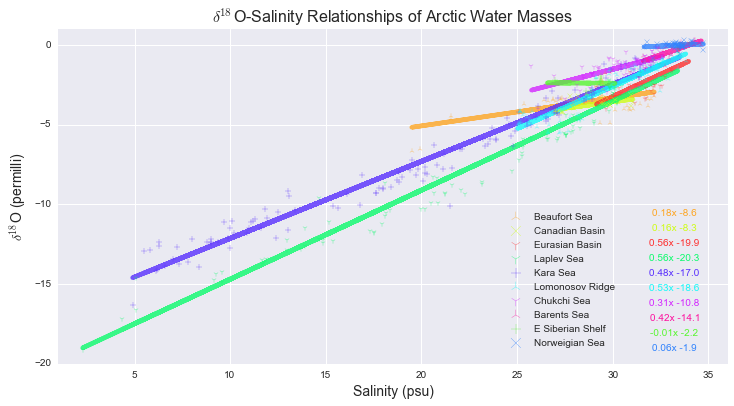

In [19]:
# place all Outlier ID's in list below...
idOdeath    = [18067]
lenOdeath   = len(idOdeath)
for toKill in range(lenOdeath):     # filters DF by natural index.
    df = df[df.index != idOdeath[toKill]]
print lenOdeath,"outlier(s) ELIMINATED!"
dfRows    = len(df.index-1)
print("\m/ -___- \m/")
print dfRows,"Records remain"

# re sort the reigonal dataframes with outliers removed. 
# We're only recalculating eurDF for this example, as the outlier belonged to that reigon.

# Convert the DB lat and lon to integers...
df.lon = df.lon.astype(int)
df.lat = df.lat.astype(int)

# Search the DB for eursian basin coordiantes, starting with lat then lon.
eurDF = df.loc[df.lat==eurLat[0]-89]         
eurDF = eurDF.loc[eurDF.lon==eurLon[0]-179]  
for i in range(1,eurPts):
    eurT  = df.loc[df.lat==eurLat[i]-89]         
    eurT  = eurT.loc[eurT.lon==eurLon[i]-179]  
    eurDF = eurDF.append(eurT)                     
# Unique count and list of arctic refernces
eurRefList = eurDF.ref.unique()
eurRefSize = eurRefList.size

# Final stats
DFList      =   (eurDF,beauDF,canDF,sibDF,lapDF,lomDF,norDF,karDF,chukDF,barDF)
arcMaster   =   eurDF.append(sibDF).append(canDF).append(beauDF).append(lapDF)\
                .append(lomDF).append(norDF).append(karDF).append(chukDF).append(barDF)
arcRef      =   arcMaster.ref.unique()
arcRefSize  =   arcRef.size


# Revive DB! back to .00 percision from 0. percision   
df=pd.read_fwf(filein,widths=fWid,header=None,names=col,skip_blank_lines=True) 
for i in range(0,files2Add):
    csv2DF=pd.read_csv(toAdd[i],sep=',',skiprows=1,names=col,na_filter=True)
    dfRows= len(df.index-1)
    df = df.append(csv2DF)     # add the contents of new csv into DB.
    dfRows= len(df.index-1)    # update the number of records in the DB.

# Run the slope analysis
pltD18O_sal()

y-intercepts suggest common origins (end-members) and the slopes suggests common surface currents. Based on these patterns we can distinguish and combine these reigonal water masses. From this we have an insight into where fresh water is coming from and where it ends up.

## 5 Plotting the Global Gridded Dataset <a id='5'></a>##
Using the database we can fill in the gaps between measurements to create a <a href='https://github.com/yinleon/NASA/blob/master/grid_d18o_7_9_15.f'>Global Gridded Dataset</a>. The Global Gridded Dataset (see also <a href='http://pubs.giss.nasa.gov/abs/le09100s.html'><i>LeGrande and Schmidt</i>, 2006</a>) is calcualted by creating a baseline (estimate) of δO<sup>18</sup> using salinity from the<a href='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA01/.Grid-1x1/.Annual/.an/'>World Ocean Atlas 2001</a> and averaging measurements from the database within each reigon. Here we will use Basemaps for geospatial data visualization and compare the estimated and calulcated output using a standard anamoly (A-B) scheme.
<br><a href='#h'>Top</a>

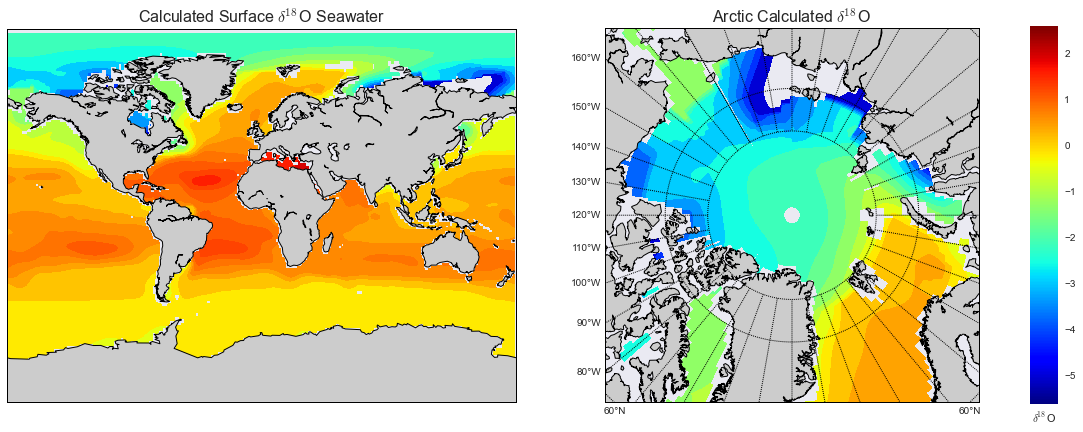

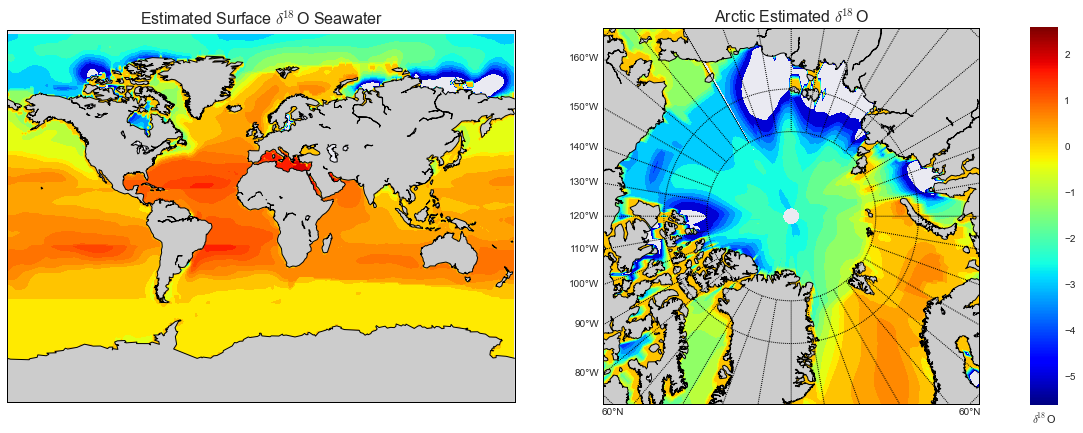

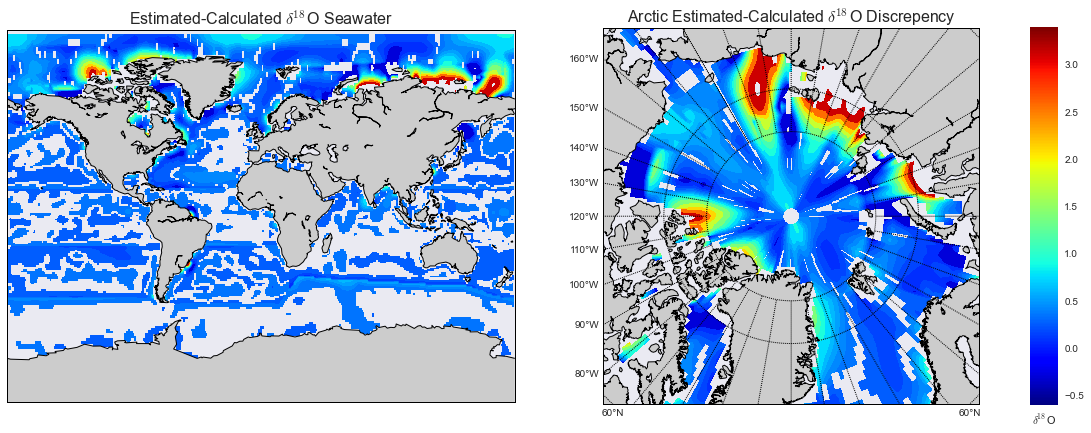

In [20]:
from matplotlib import gridspec
import matplotlib as mpl

# Files to be read...
infile1='dbO18_CALC_OG'                 # Model database averaged into baseline estimate from WOA (fortran sequential binary)
infile2='dbO18_EST_OG'                  # Model estimate from WOA before values are averaged in   (fortran sequential binary)

# Parameters
im = 360
jm = 180
lm = 33
sizeTitle = 80  # bytesize of the header of each sequential binary record (a relic of Fortran)
offSet = 2      # bytesize of non-sense at the begning of fortran sequential binary file.
sizeData = im*jm
d1 = np.float32 # datatype of bytes of the sequential binray file
skip2 = -1.0e+30
depthLVL = 3    # this can be adjusted up to 33 for depth(which coincides with Levitus Levels (lm) from WOA2001)

d18o_model=np.zeros((360,180,33))
d18o_est=np.zeros((360,180,33))
d18o_est_calc=np.zeros((360,180))

# import files...
f1=open(infile1,"rb")
f2=open(infile2,"rb")

# Read in the calculated global gridded dataset
f1.read(offSet)               #skip first 2 bytes of nonsense
header = f1.read(sizeTitle+2) #read the first 80+2 bytes for title 
record = np.fromfile(f1,dtype=d1,count=sizeData)    #read the first record from the Fortran file
recordT = np.reshape(record,(180,360)).transpose()  #turn the 1D input into two dimesnions and transpose for lon,lat
d18o_model[:,:,0] = recordT

# The next records are more predictable and can be read with a forloop
for k in range(1,depthLVL):
    f1.read(8)
    header = f1.read(sizeTitle)
    record = np.fromfile(f1,dtype=d1,count=sizeData)
    recordT= np.reshape(record,(180,360)).transpose()
    d18o_model[:,:,k]=recordT

# Read in the estimated global gridded dataset
f2.read(offSet)               #skip first 2 bytes of nonsense
header = f2.read(sizeTitle+2) #read the first 80+2 bytes for title 
record = np.fromfile(f2,dtype=d1,count=sizeData)    #read the first record from the Fortran file
recordT = np.reshape(record,(180,360)).transpose()  #turn the 1D input into two dimesnions and transpose for lon,lat
d18o_est[:,:,0] = recordT

# The next records are more predictable and can be read with a forloop
for k in range(1,depthLVL):
    f2.read(8)
    header = f2.read(sizeTitle)
    record = np.fromfile(f2,dtype=d1,count=sizeData)
    recordT=np.reshape(record,(180,360)).transpose()
    d18o_est[:,:,k]=recordT
    
# Scrub out -1e30 for NaN
for j in range(0,jm):
    for i in range(0,im):
        for k in range(0,lm):
            # Scrub out -1e30 for NaN for model output
            if(d18o_model[i,j,k]<=skip2):
                d18o_model[i,j,k]=np.nan
            if(d18o_est[i,j,k]<=skip2):
                d18o_est[i,j,k]=np.nan
# mask NaN values
d18o_model=np.ma.masked_invalid(d18o_model)
d18o_est=np.ma.masked_invalid(d18o_est)

# Difference between est and calc...
for j in range(0,jm):
    for i in range(0,im): 
        if(np.isnan(d18o_model[i,j,0]) or np.isnan(d18o_est[i,j,0])):
            d18o_est_calc[i,j]=np.nan  # ignore NaN
        else:
            d18o_est_calc[i,j]=d18o_model[i,j,0]-d18o_est[i,j,0]
            if(d18o_est_calc[i,j]>-.01) and (d18o_est_calc[i,j]<.01):
                d18o_est_calc[i,j]=np.nan

# Mask the NaN values
d18o_est_calc=np.ma.masked_invalid(d18o_est_calc)

# Let's plot these guys...
lon = np.arange(-180.0,180.0,1)
lat = np.arange(-90.0,90.0,1)

#map1 = Basemap(projection='mill', lat_0=0, lon_0=0) #why is there a -4 offset on iPython (should be 0)?
colors=[-5.6,-4.4,-4.0,-3.6,-3.2,-2.8,-2.4,-2.0,-1.6,-1.2,-.8,-.4,
        -.2,.2,.4,.6,.8,1.0,1.2,1.6,2.0,2.4]  
colors2=[-.6-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.6,.8,1.,1.4,1.8,2.2,2.8,3.4]
Vmin2 = -.6
Vmax2 = 3.4

# Make map for model output
fig, axes = plt.subplots(figsize=(20,14),nrows=1, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((2,2)), vmin=Vmin, vmax=Vmax, cmap=cmap1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.835, 0.325, 0.02, 0.375])
cbar_ax.set_xlabel('$\delta^{18}$O')
fig.colorbar(im, cax=cbar_ax)

gs = gridspec.GridSpec(1, 2, width_ratios=[1.36, 1])
axes[0] = plt.subplot(gs[0])
axes[1] = plt.subplot(gs[1])
map1 = Basemap(projection='mill', lat_0=0, lon_0=0,ax=axes[0]) #why is there a -4 offset on iPython (should be 0)?
x,y = map1(*np.meshgrid(lon, lat))
map1.contourf(x, y, np.transpose(d18o_model[:,:,0]),colors,cmap=cmap1)
map1.drawcoastlines()
map1.fillcontinents()
map1.drawmapboundary()
axes[0].set_title('Calculated Surface $\delta^{18}$O Seawater',size=titleS)

map2 = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l',ax=axes[1])
x2,y2 = map2(*np.meshgrid(lon, lat))
parallels = np.arange(-90.,90.,15.)
meridians = np.arange(-180.,181.,10.)
map2.drawparallels(parallels,labels=[False,False,False,True])
map2.drawmeridians(meridians,labels=[True,False,False,False])
map2.drawcoastlines()
map2.fillcontinents()
map2.drawmapboundary()
map2.contourf(x2, y2, np.transpose(d18o_model[:,:,0]),colors,cmap=cmap1)
axes[1].set_title('Arctic Calculated $\delta^{18}$O',fontsize=titleS)
plt.show()

# Plot 2
fig, axes = plt.subplots(figsize=(20,14),nrows=1, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((2,2)), vmin=Vmin, vmax=Vmax, cmap=cmap1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.835, 0.325, 0.02, 0.375])
cbar_ax.set_xlabel('$\delta^{18}$O')
fig.colorbar(im, cax=cbar_ax)

gs = gridspec.GridSpec(1, 2, width_ratios=[1.35, 1])
axes[0] = plt.subplot(gs[0])
axes[1] = plt.subplot(gs[1])
map1 = Basemap(projection='mill', lat_0=0, lon_0=0,ax=axes[0])
map1.contourf(x, y, np.transpose(d18o_est[:,:,0]),colors,cmap=cmap1)
map1.drawcoastlines()
map1.fillcontinents()
map1.drawmapboundary()
axes[0].set_title('Estimated Surface $\delta^{18}$O Seawater',size=titleS)

map2 = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l',ax=axes[1])
x2,y2 = map2(*np.meshgrid(lon, lat))
parallels = np.arange(-90.,90.,15.)
meridians = np.arange(-180.,181.,10.)
map2.drawparallels(parallels,labels=[False,False,False,True])
map2.drawmeridians(meridians,labels=[True,False,False,False])
map2.drawcoastlines()
map2.fillcontinents()
map2.drawmapboundary()
map2.contourf(x2, y2, np.transpose(d18o_est[:,:,0]),colors,cmap=cmap1)
axes[1].set_title('Arctic Estimated $\delta^{18}$O',fontsize=titleS)
plt.show()

# Plot 3
fig, axes = plt.subplots(figsize=(20,14),nrows=1, ncols=2)
for ax in axes.flat:
    im = ax.imshow(np.random.random((2,2)), vmin=Vmin2, vmax=Vmax2, cmap=cmap1)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.835, 0.325, 0.02, 0.375])
cbar_ax.set_xlabel('$\delta^{18}$O')
fig.colorbar(im, cax=cbar_ax) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1.35, 1])
axes[0] = plt.subplot(gs[0])
axes[1] = plt.subplot(gs[1])
map1 = Basemap(projection='mill', lat_0=0, lon_0=0,ax=axes[0])
map1.contourf(x, y, np.transpose(d18o_est_calc[:,:]),colors2,cmap=cmap1)
map1.drawcoastlines()
map1.fillcontinents()
map1.drawmapboundary()
axes[0].set_title('Estimated-Calculated $\delta^{18}$O Seawater',size=titleS)

map2 = Basemap(projection='npstere',boundinglat=68,lon_0=330,resolution='l',ax=axes[1])
x2,y2 = map2(*np.meshgrid(lon, lat))
parallels = np.arange(-90.,90.,15.)
meridians = np.arange(-180.,181.,10.)
map2.drawparallels(parallels,labels=[False,False,False,True])
map2.drawmeridians(meridians,labels=[True,False,False,False])
map2.drawcoastlines()
map2.fillcontinents()
map2.drawmapboundary()
map2.contourf(x2, y2, np.transpose(d18o_est_calc[:,:]),colors2,cmap=cmap1)
axes[1].set_title('Arctic Estimated-Calculated $\delta^{18}$O Discrepency',fontsize=titleS)
plt.show()
